<a href="https://colab.research.google.com/github/vikram2727/m.tech-thesis-work/blob/main/m_tech_final_case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
# import all the libraries required for this chapter
# Machine Learning Libraries: scikit-learn, keras and tensorflow

# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize, Normalizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.compose import ColumnTransformer
import sklearn.cluster as cluster
import lightgbm as lgb
import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.utils import np_utils
from sklearn.feature_selection import RFE

# plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  # visualization
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.offsetbox import AnchoredText
# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)
plt.style.use("seaborn-white")
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

In [179]:
!git clone  https://github.com/vikram2727/o-g_data_analsis
!pip install lasio
import lasio

fatal: destination path 'o-g_data_analsis' already exists and is not an empty directory.


# Step 1. Load and Display the Well-log Datasets

In [180]:
import glob
import os

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join("/content/o-g_data_analsis/well_logs", "*.las")))

well_df = [0] * 3

for i in range(len(paths)):
  # read with lasio
  well = lasio.read(paths[i])

  # convert to dataframe
  df = well.df()

  # in this dataframe, depth is positioned as index, not as column
  # so better to change depth index to column
  well_df[i] = df.reset_index()

well1, well2, well3 = well_df

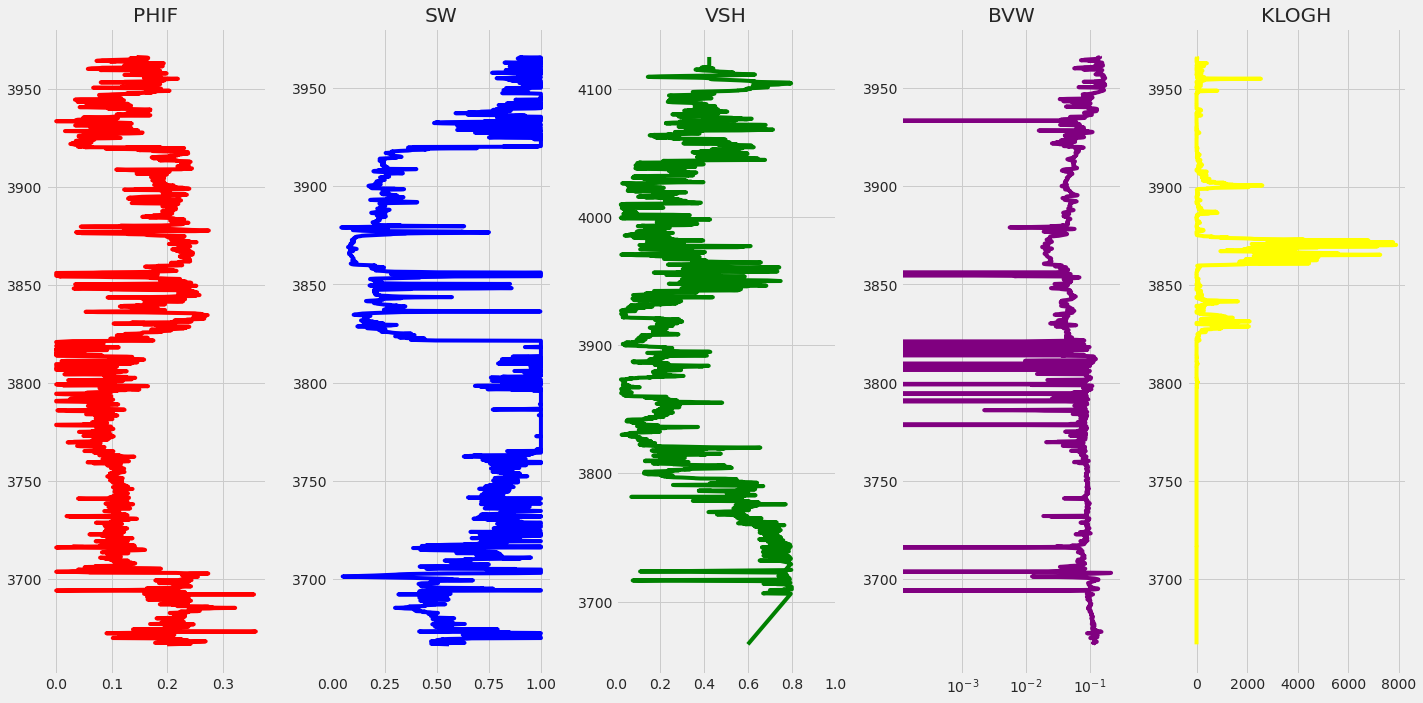

In [181]:
plt.style.use('fivethirtyeight')
# Display train well data
well = well1 # train wells: well2, well3,

# define what logs are we going to us
logs = ['PHIF','SW','VSH','BVW','KLOGH']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['red', 'blue', 'green', 'purple','yellow']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 1)
#ax[4].set_xlim(0, 1000)
#ax[].set_xlim(0, 1000)
plt.tight_layout(1.1)
plt.show()

In [182]:
well3.info(verbose = False, buf=None, max_cols=None, memory_usage=None, null_counts=None)
well3.rename(columns = {'BWV':'BVW'}, inplace = True) 
well3.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7013 entries, 0 to 7012
Columns: 9 entries, DEPTH to VSH
dtypes: float64(9)
memory usage: 493.2 KB


DEPTH     BVW      DT     KLOGH  ...    PHIF  SAND_FLAG      SW     VSH
count 7013.00 7012.00 7012.00   6782.00  ... 6886.00    6886.00 6886.00 1882.00
mean  4084.02    0.10   93.88   1848.90  ...    0.11       0.27    0.96    0.39
std    308.55    0.09  101.85  16633.80  ...    0.10       0.44    0.13    0.31
min   3549.70    0.00   13.09      0.00  ...    0.00       0.00    0.08   -0.25
25%   3816.86    0.02   66.30      0.00  ...    0.02       0.00    1.00    0.24
50%   4084.02    0.09   75.07      0.01  ...    0.09       0.00    1.00    0.34
75%   4351.17    0.16   94.73      3.80  ...    0.19       1.00    1.00    0.45
max   4618.33    0.35 1019.10 760405.25  ...    0.35       1.00    1.00    2.46

[8 rows x 9 columns]

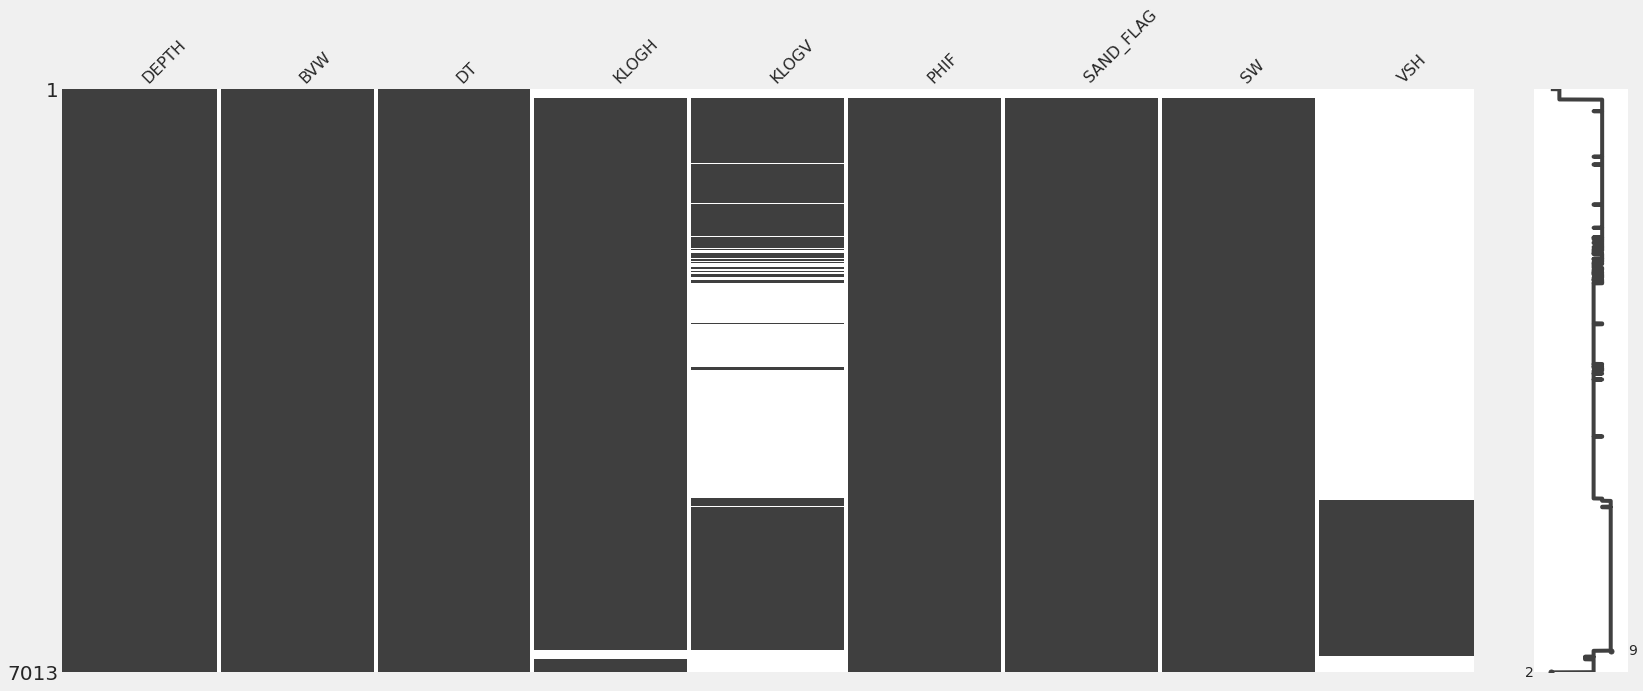

In [183]:
import missingno as msno
msno.matrix(well3)

In [184]:
avg = well3['KLOGV'].mean()
well3['KLOGV'].fillna(value = avg ,  inplace=True)
avg = well3['KLOGH'].mean()
well3['KLOGH'].fillna(value = avg ,  inplace=True)

avg = well3['PHIF'].mean()
well3['PHIF'].fillna(value = avg ,  inplace=True)

avg = well3['SW'].mean()
well3['SW'].fillna(value = avg ,  inplace=True)

avg = well3['SAND_FLAG'].mean()
well3['SAND_FLAG'].fillna(value = avg ,  inplace=True)

avg = well3['BVW'].mean()
well3['BVW'].fillna(value = avg ,  inplace=True)

avg = well3['VSH'].mean()
well3['VSH'].fillna(value = avg ,  inplace=True)

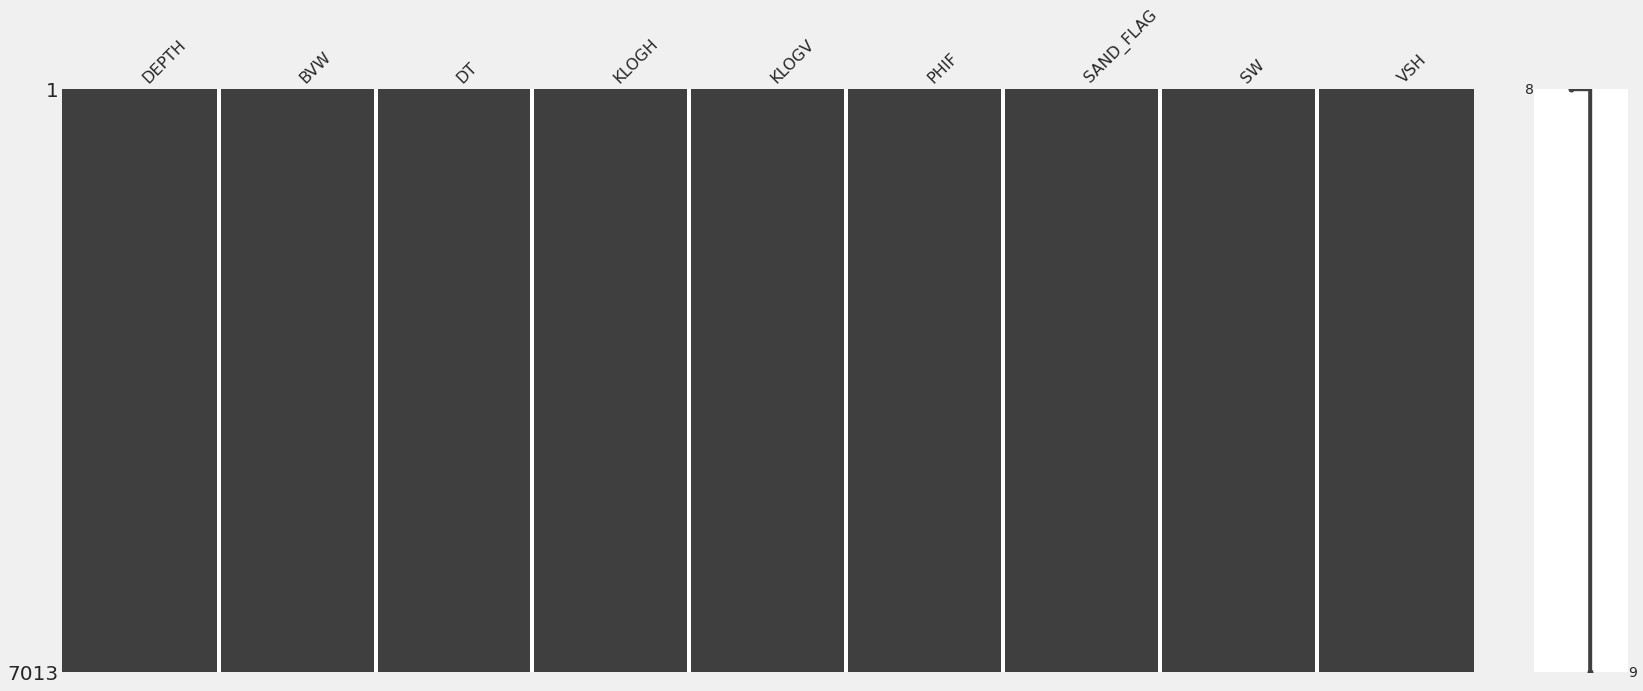

In [185]:
msno.matrix(well3)

# Step 2. Data Preparation

In [186]:
# lower limit
low = [3825,4040,3700]

# upper limit
up = [3920,4180,3800]

# train columns to use
train_cols = ['DEPTH','PHIF','SW','VSH','BVW', 'KLOGH', 'KLOGV']

# test columns to use
test_cols = ['DEPTH','PHIF','SW','VSH','BVW', 'KLOGH']

well_df_restrict = [0] * 3

for i in range(len(well_df)):
  # restrict depth within the given lower and upper limit
  df = well_df[i].loc[(well_df[i]['DEPTH'] >= low[i]) & (well_df[i]['DEPTH'] <= up[i])]

  if i == 1 or i == 2:
    # the train data, drop unwanted columns
    well_df_restrict[i] = df[train_cols]
  
  else:
    # the test data, drop unwanted columns
    well_df_restrict[i] = df[test_cols]

well1, well2, well3 = well_df_restrict

# as we can see, both ends already not have NaNs
well2.describe()

DEPTH   PHIF     SW    VSH    BVW   KLOGH   KLOGV
count  918.00 918.00 918.00 918.00 918.00  918.00  918.00
mean  4110.00   0.20   0.95   0.20   0.19  448.91  395.37
std     40.41   0.05   0.13   0.15   0.05  572.13  511.05
min   4040.12   0.00   0.12   0.02   0.00    0.00    0.00
25%   4075.06   0.19   0.96   0.08   0.18    3.55    3.92
50%   4110.00   0.21   1.00   0.15   0.20  180.11  155.65
75%   4144.94   0.22   1.00   0.31   0.22  772.18  667.20
max   4179.87   0.27   1.00   0.94   0.25 3296.89 3079.10

In [187]:
well2.corr(method ='pearson')

DEPTH  PHIF    SW   VSH   BVW  KLOGH  KLOGV
DEPTH   1.00  0.08 -0.21  0.35 -0.03  -0.14  -0.14
PHIF    0.08  1.00  0.05 -0.15  0.89   0.21   0.19
SW     -0.21  0.05  1.00 -0.03  0.48   0.12   0.11
VSH     0.35 -0.15 -0.03  1.00 -0.16  -0.64  -0.64
BVW    -0.03  0.89  0.48 -0.16  1.00   0.24   0.23
KLOGH  -0.14  0.21  0.12 -0.64  0.24   1.00   0.99
KLOGV  -0.14  0.19  0.11 -0.64  0.23   0.99   1.00

In [188]:
well2.corr(method ='kendall')

DEPTH  PHIF    SW   VSH  BVW  KLOGH  KLOGV
DEPTH   1.00  0.07 -0.12  0.17 0.01  -0.14  -0.16
PHIF    0.07  1.00 -0.18  0.08 0.82   0.15   0.10
SW     -0.12 -0.18  1.00 -0.20 0.05   0.17   0.18
VSH     0.17  0.08 -0.20  1.00 0.02  -0.75  -0.82
BVW     0.01  0.82  0.05  0.02 1.00   0.20   0.14
KLOGH  -0.14  0.15  0.17 -0.75 0.20   1.00   0.92
KLOGV  -0.16  0.10  0.18 -0.82 0.14   0.92   1.00

In [189]:
well2.corr(method ='spearman')

DEPTH  PHIF    SW   VSH  BVW  KLOGH  KLOGV
DEPTH   1.00  0.08 -0.18  0.27 0.01  -0.22  -0.25
PHIF    0.08  1.00 -0.23  0.11 0.92   0.22   0.13
SW     -0.18 -0.23  1.00 -0.26 0.06   0.22   0.24
VSH     0.27  0.11 -0.26  1.00 0.03  -0.84  -0.94
BVW     0.01  0.92  0.06  0.03 1.00   0.29   0.21
KLOGH  -0.22  0.22  0.22 -0.84 0.29   1.00   0.95
KLOGV  -0.25  0.13  0.24 -0.94 0.21   0.95   1.00

In [190]:
# merge dataframes
well_train = pd.concat([well2, well3])
well_pred = pd.concat([well1])

# assign names
names = ['15_9-19 A', '15_9-19 BT2', '15_9-19 SR']

names_train = []
names_pred = []
for i in range(len(well_df_restrict)):
  if i == 1 or i == 2 :
    # train data, assign names 
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_train.append(_)
  else:
    # test data, assign names
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_pred.append(_)

# concatenate inside list
import itertools

names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# include well names to the train and pred dataframe
well_train['WELL'] = names_train
well_pred['WELL'] = names_pred

# move the depth column to the right
depth_train, depth_pred = well_train.pop('DEPTH'), well_pred.pop('DEPTH')
well_train['DEPTH'], well_pred['DEPTH'] = depth_train, depth_pred



well_train.describe()

PHIF      SW     VSH     BVW     KLOGH     KLOGV   DEPTH
count 1574.00 1574.00 1574.00 1574.00   1574.00   1574.00 1574.00
mean     0.23    0.96    0.28    0.22   6266.07   6920.25 3959.97
std      0.06    0.11    0.15    0.06  22411.54  26400.29  181.15
min      0.00    0.12    0.02    0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19     12.76     16.09 3760.05
50%      0.22    1.00    0.37    0.22    484.61    418.72 4060.01
75%      0.28    1.00    0.39    0.27   1699.70   1552.85 4119.94
max      0.35    1.00    0.94    0.35 238779.50 290363.47 4179.87

In [191]:
wellnames = well_train['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [192]:
well_pred.describe()

PHIF     SW    VSH    BVW   KLOGH   DEPTH
count 623.00 623.00 623.00 623.00  623.00  623.00
mean    0.19   0.25   0.16   0.04  754.72 3872.48
std     0.05   0.14   0.09   0.01 1448.17   27.43
min     0.00   0.04   0.02   0.00    0.10 3825.09
25%     0.17   0.18   0.09   0.03   29.19 3848.79
50%     0.21   0.23   0.17   0.04  111.23 3872.48
75%     0.23   0.27   0.22   0.05  650.68 3896.18
max     0.28   1.00   0.48   0.08 7899.63 3919.88

In [193]:
#well_train.to_csv('/content/sample_data.csv', index=False)

#well_pred.to_csv('/content/sample1.csv', index=False)


In [194]:
#well_train = pd.read_excel('/content/o-g_data_analsis/well_train.xlsx')
#well_pred = pd.read_csv('/content/o-g_data_analsis/well log/sample.csv')

In [195]:
well_train.insert(4,'HMR', well_train['KLOGH'].values/well_train['PHIF'].values,True)

In [196]:
well_train.describe()

PHIF      SW     VSH     BVW     HMR     KLOGH     KLOGV   DEPTH
count 1574.00 1574.00 1574.00 1574.00 1567.00   1574.00   1574.00 1574.00
mean     0.23    0.96    0.28    0.22     inf   6266.07   6920.25 3959.97
std      0.06    0.11    0.15    0.06     nan  22411.54  26400.29  181.15
min      0.00    0.12    0.02    0.00    0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19   74.87     12.76     16.09 3760.05
50%      0.22    1.00    0.37    0.22 2282.70    484.61    418.72 4060.01
75%      0.28    1.00    0.39    0.27 7485.87   1699.70   1552.85 4119.94
max      0.35    1.00    0.94    0.35     inf 238779.50 290363.47 4179.87

In [197]:
# Replacing infinite with nan
well_train.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
well_train.dropna(inplace=True)
  
# Printing df
well_train.describe()

PHIF      SW     VSH     BVW       HMR     KLOGH     KLOGV   DEPTH
count 1560.00 1560.00 1560.00 1560.00   1560.00   1560.00   1560.00 1560.00
mean     0.23    0.96    0.28    0.22  19878.75   6322.31   6982.28 3958.34
std      0.06    0.11    0.14    0.06  66315.69  22504.04  26510.40  181.07
min      0.00    0.12    0.02    0.00      0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19     71.68     15.77     17.44 3759.52
50%      0.22    1.00    0.37    0.22   2245.48    490.73    434.60 4058.95
75%      0.28    1.00    0.39    0.27   7346.22   1700.08   1588.87 4119.11
max      0.35    1.00    0.90    0.35 689960.62 238779.50 290363.47 4179.72

In [198]:
a = np.sqrt(well_train[['HMR']].sum(axis=1))
a


1785   89.77
1786   64.23
1787   78.05
1788   91.54
1789   82.01
        ... 
1638   33.36
1639   31.97
1640   30.67
1641   29.38
1642   27.58
Length: 1560, dtype: float64

In [199]:

cols = ['HMR']
hmr = pd.DataFrame(a, columns=cols)



In [200]:
well_train['HMR'] = hmr['HMR'].values

well_train.describe()

PHIF      SW     VSH     BVW     HMR     KLOGH     KLOGV   DEPTH
count 1560.00 1560.00 1560.00 1560.00 1560.00   1560.00   1560.00 1560.00
mean     0.23    0.96    0.28    0.22   80.09   6322.31   6982.28 3958.34
std      0.06    0.11    0.14    0.06  116.07  22504.04  26510.40  181.07
min      0.00    0.12    0.02    0.00    0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19    8.47     15.77     17.44 3759.52
50%      0.22    1.00    0.37    0.22   47.39    490.73    434.60 4058.95
75%      0.28    1.00    0.39    0.27   85.71   1700.08   1588.87 4119.11
max      0.35    1.00    0.90    0.35  830.64 238779.50 290363.47 4179.72

In [201]:
well_train.rename(columns = {'KLOGV':'Kv', 'KLOGH':'Kh'}, inplace = True)

In [202]:
well_train.describe()

PHIF      SW     VSH     BVW     HMR        Kh        Kv   DEPTH
count 1560.00 1560.00 1560.00 1560.00 1560.00   1560.00   1560.00 1560.00
mean     0.23    0.96    0.28    0.22   80.09   6322.31   6982.28 3958.34
std      0.06    0.11    0.14    0.06  116.07  22504.04  26510.40  181.07
min      0.00    0.12    0.02    0.00    0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19    8.47     15.77     17.44 3759.52
50%      0.22    1.00    0.37    0.22   47.39    490.73    434.60 4058.95
75%      0.28    1.00    0.39    0.27   85.71   1700.08   1588.87 4119.11
max      0.35    1.00    0.90    0.35  830.64 238779.50 290363.47 4179.72

In [203]:
wellnames = well_train['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [204]:

#sns.pairplot(well_train, vars=feature_target, diag_kind = 'kde')
           

In [205]:
data = {'Logs': ['PHIF',	'SW',	'VSH',	'BVW','HMR','KLOGH',	'KLOGV'],
        'std' : [0.06,	0.11,	0.14,	0.06,	116.07,	22504.04,	26510.40		],
        'mean': [0.23,	0.96,	0.28,	0.22,	80.09,	6322.31,	6982.28]}
variance_df = pd.DataFrame(data)

variance_df.insert(3,'variance', variance_df['std'].values/variance_df['mean'].values,True)
variance_df

Logs      std    mean  variance
0   PHIF     0.06    0.23      0.26
1     SW     0.11    0.96      0.11
2    VSH     0.14    0.28      0.50
3    BVW     0.06    0.22      0.27
4    HMR   116.07   80.09      1.45
5  KLOGH 22504.04 6322.31      3.56
6  KLOGV 26510.40 6982.28      3.80

In [206]:
px.box(well_train, x='Kv', orientation='h', points='all')

In [207]:
px.box(well_train, x='Kh', orientation='h', points='all')

In [208]:
px.box(well_train, x='HMR', orientation='h', points='all')

In [209]:
plt.rcParams.update({'font.size': 18})

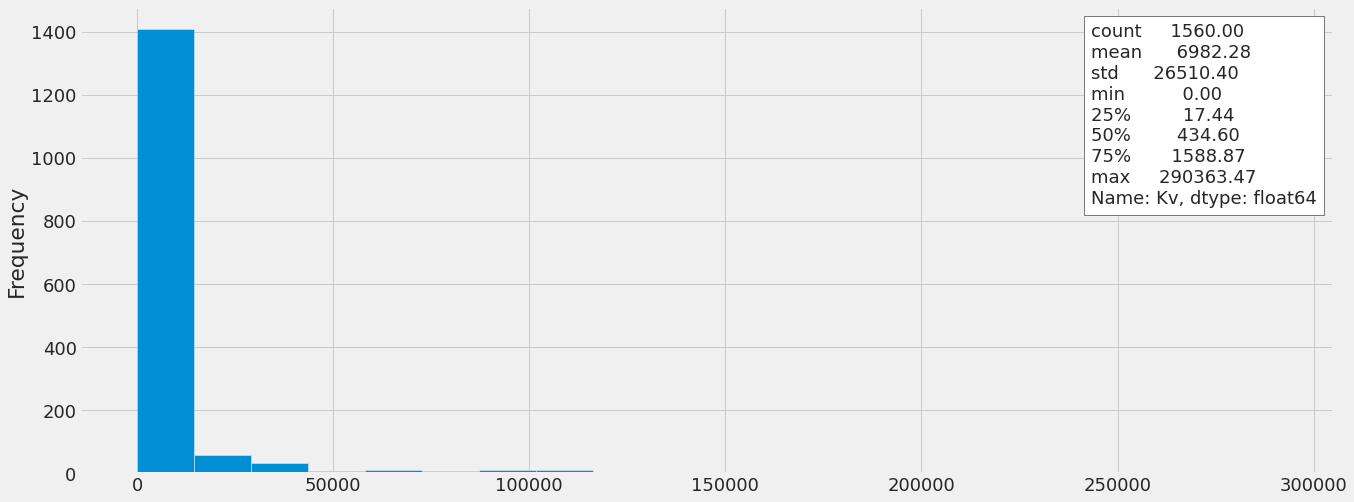

In [210]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(20,8))

well_train['Kv'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train['Kv'].describe()), loc=1)
ax.add_artist(anchored_text)

## here we can se high degree of variance((std/mean) is high) we need to go for smoothing technique
## after smoothing we can go for normalization fro more better distribution

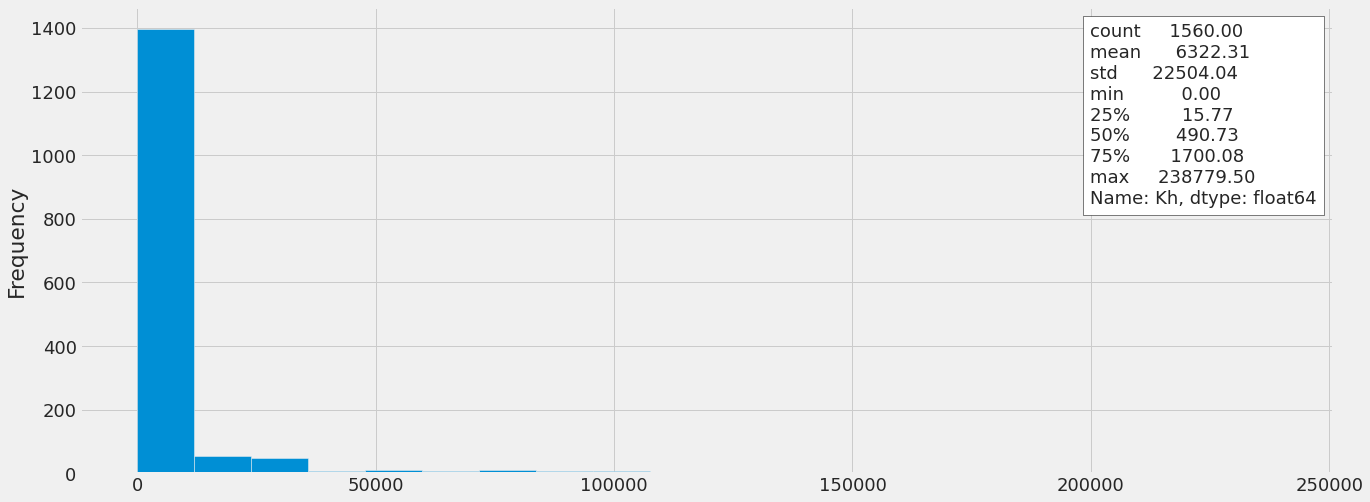

In [211]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(20,8))

well_train['Kh'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train['Kh'].describe()), loc=1)
ax.add_artist(anchored_text)

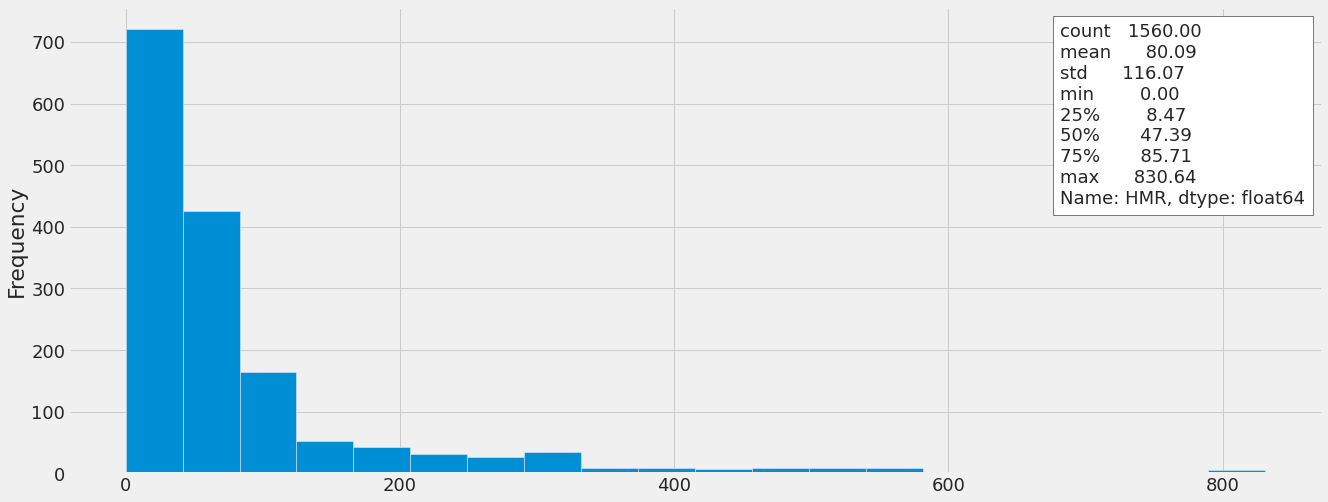

In [212]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(20,8))

well_train['HMR'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train['HMR'].describe()), loc=1)
ax.add_artist(anchored_text)

# Step 3. Smoothing High Variance Data

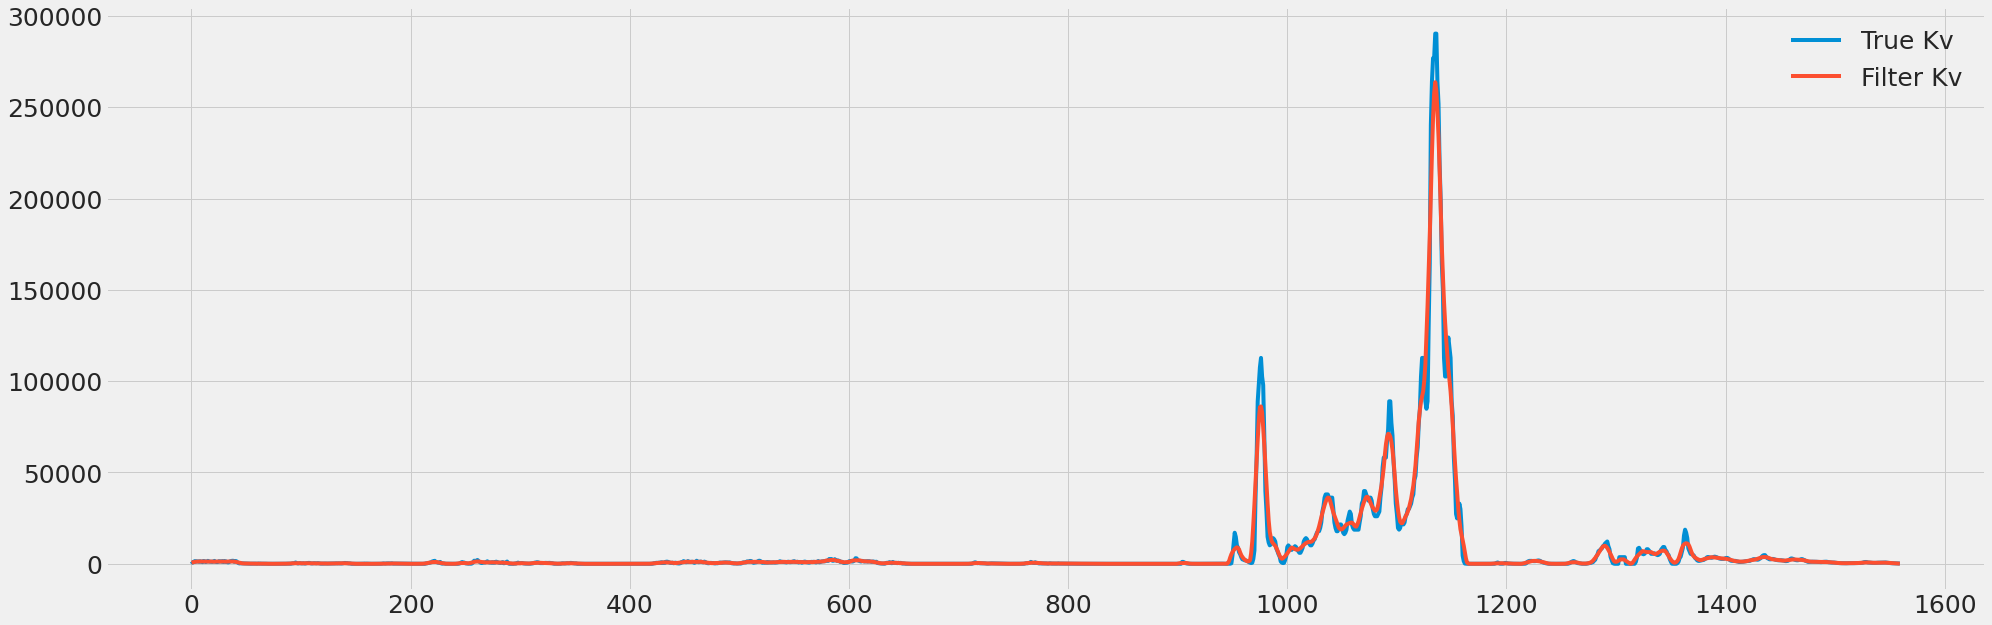

In [213]:
## smoothing vertical permeability 
p = well_train['Kv'].values
filter_length = 9
tair_moving_avg = np.convolve(p,np.ones((filter_length)),mode = 'same')
tair_moving_avg /= filter_length

plt.rcParams.update({'font.size': 25})
plt.figure(figsize = (30,10))
plt.plot(p, label = 'True Kv')
plt.plot(tair_moving_avg, label = 'Filter Kv')
plt.legend()
plt.show()

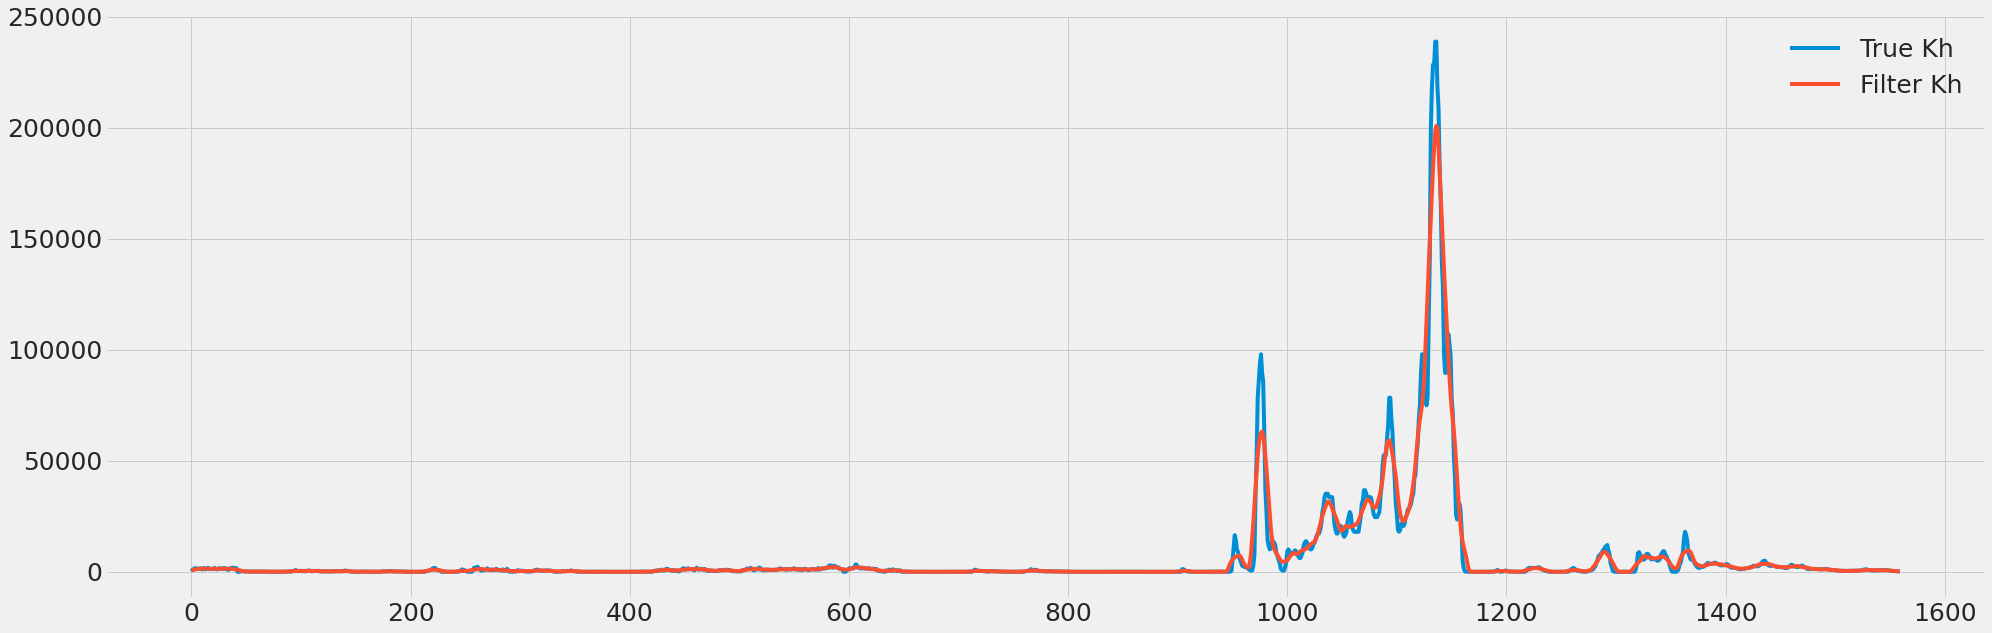

In [214]:
q = well_train['Kh'].values
filter_length = 12
tair_moving_avg1 = np.convolve(q,np.ones((filter_length)),mode = 'same')
tair_moving_avg1 /= filter_length

#plt.rcParams.update({'font.size': 35})
plt.figure(figsize = (30,10))
plt.plot(q, label = 'True Kh')
plt.plot(tair_moving_avg1, label = 'Filter Kh')
plt.legend()
plt.show()

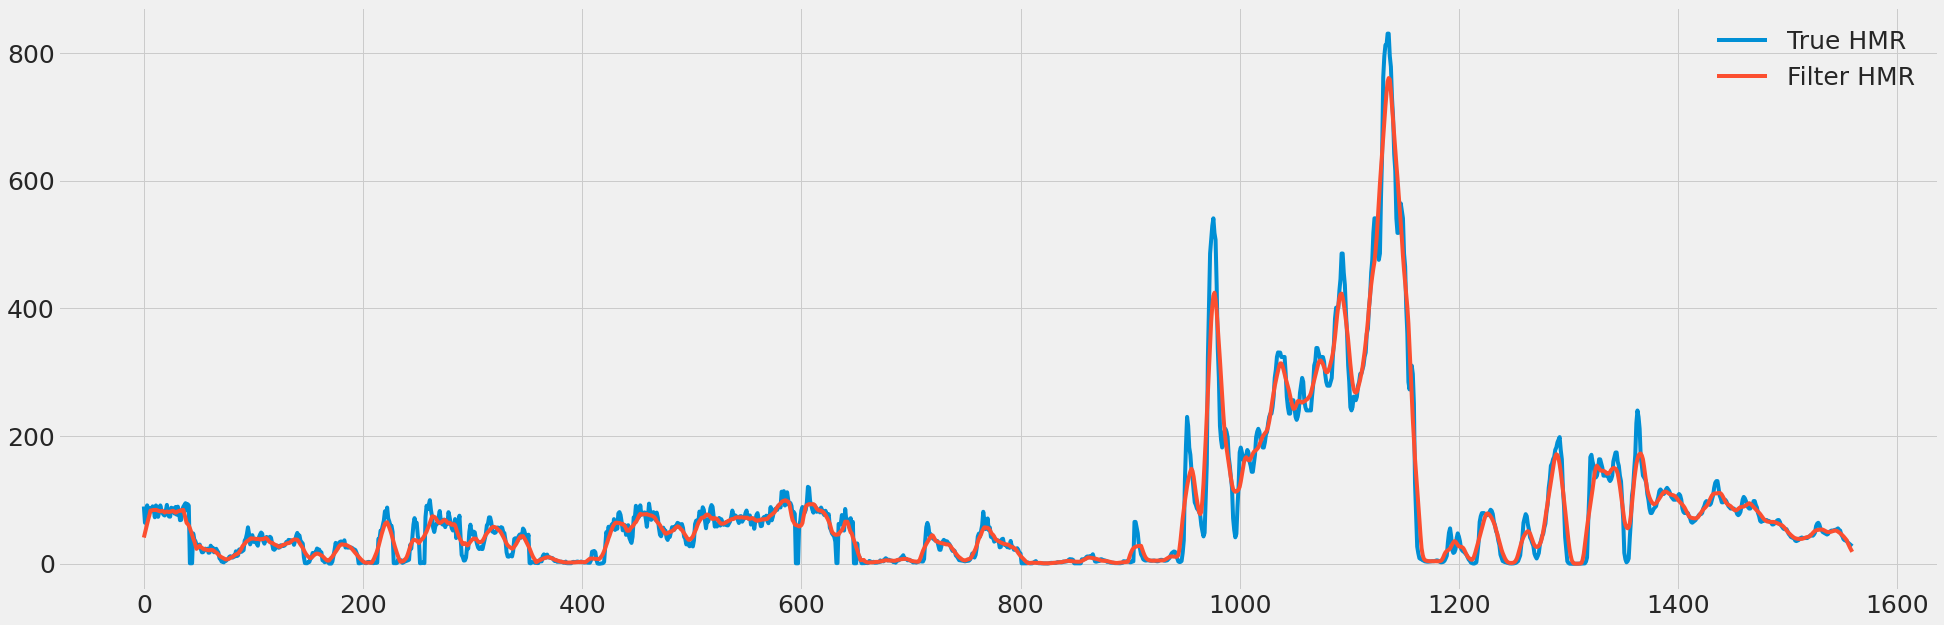

In [215]:
r = well_train['HMR'].values
filter_length = 12
tair_moving_avg2 = np.convolve(r,np.ones((filter_length)),mode = 'same')
tair_moving_avg2 /= filter_length

#plt.rcParams.update({'font.size': })
plt.figure(figsize = (30,10))
plt.plot(r, label = 'True HMR')
plt.plot(tair_moving_avg2, label = 'Filter HMR')
plt.legend()
plt.show()

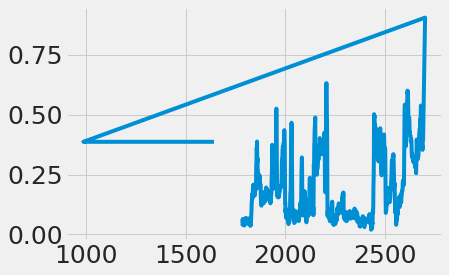

In [216]:
plt.plot(well_train['VSH'])

In [217]:
# Making anotother DataFrame for training dataset


In [218]:
col = ['S_KLOGH']
kh = pd.DataFrame(tair_moving_avg1, columns=col)

cols = ['S_KLOGV']
kv = pd.DataFrame(tair_moving_avg, columns=cols)

cols = ['S_HMR']
hmr = pd.DataFrame(tair_moving_avg2, columns=cols)

well_train_kvkh = pd.concat([hmr,kh,kv],axis=1)

#col = ['S_KLOGH']
#kh = pd.DataFrame(tair_moving_avg1, columns=col)
well_train['Kv'] = well_train_kvkh['S_KLOGV'].values
well_train['Kh'] = well_train_kvkh['S_KLOGH'].values
well_train['HMR'] = well_train_kvkh['S_HMR'].values
well_train.describe()

PHIF      SW     VSH     BVW     HMR        Kh        Kv   DEPTH
count 1560.00 1560.00 1560.00 1560.00 1560.00   1560.00   1560.00 1560.00
mean     0.23    0.96    0.28    0.22   79.99   6321.05   6981.39 3958.34
std      0.06    0.11    0.14    0.06  111.55  21120.79  25324.28  181.07
min      0.00    0.12    0.02    0.00    0.14      0.01      0.05 3700.12
25%      0.20    0.96    0.12    0.19   15.14     84.67     57.13 3759.52
50%      0.22    1.00    0.37    0.22   47.45    562.30    496.55 4058.95
75%      0.28    1.00    0.39    0.27   83.80   1937.73   1730.25 4119.11
max      0.35    1.00    0.90    0.35  760.99 200802.19 263758.51 4179.72

In [219]:
well_train

PHIF   SW  VSH  BVW   HMR      Kh      Kv         WELL   DEPTH
1785  0.19 1.00 0.04 0.19 41.09  654.64  623.34  15_9-19 BT2 4040.12
1786  0.18 1.00 0.06 0.18 48.20  776.02  771.55  15_9-19 BT2 4040.28
1787  0.19 1.00 0.05 0.19 55.05  879.99  915.28  15_9-19 BT2 4040.43
1788  0.20 1.00 0.04 0.20 62.55 1009.23 1037.23  15_9-19 BT2 4040.58
1789  0.19 1.00 0.05 0.19 69.71 1121.87 1190.85  15_9-19 BT2 4040.73
...    ...  ...  ...  ...   ...     ...     ...          ...     ...
1638  0.26 1.00 0.39 0.26 32.45  305.08  233.97   15_9-19 SR 3799.33
1639  0.26 1.00 0.39 0.26 28.63  258.57  198.42   15_9-19 SR 3799.48
1640  0.25 1.00 0.39 0.26 25.05  217.89  166.08   15_9-19 SR 3799.64
1641  0.25 1.00 0.39 0.25 21.83  185.32  135.23   15_9-19 SR 3799.79
1642  0.25 1.00 0.39 0.25 18.74  155.54  105.80   15_9-19 SR 3799.94

[1560 rows x 9 columns]

In [220]:
a = ['WELL','DEPTH','PHIF',	'SW',	'VSH'	,'BVW',	'HMR',	'Kh'	,'Kv']
we = well_train[a]
we

WELL   DEPTH  PHIF   SW  VSH  BVW   HMR      Kh      Kv
1785  15_9-19 BT2 4040.12  0.19 1.00 0.04 0.19 41.09  654.64  623.34
1786  15_9-19 BT2 4040.28  0.18 1.00 0.06 0.18 48.20  776.02  771.55
1787  15_9-19 BT2 4040.43  0.19 1.00 0.05 0.19 55.05  879.99  915.28
1788  15_9-19 BT2 4040.58  0.20 1.00 0.04 0.20 62.55 1009.23 1037.23
1789  15_9-19 BT2 4040.73  0.19 1.00 0.05 0.19 69.71 1121.87 1190.85
...           ...     ...   ...  ...  ...  ...   ...     ...     ...
1638   15_9-19 SR 3799.33  0.26 1.00 0.39 0.26 32.45  305.08  233.97
1639   15_9-19 SR 3799.48  0.26 1.00 0.39 0.26 28.63  258.57  198.42
1640   15_9-19 SR 3799.64  0.25 1.00 0.39 0.26 25.05  217.89  166.08
1641   15_9-19 SR 3799.79  0.25 1.00 0.39 0.25 21.83  185.32  135.23
1642   15_9-19 SR 3799.94  0.25 1.00 0.39 0.25 18.74  155.54  105.80

[1560 rows x 9 columns]

In [221]:
well2 = (well_train[well_train['WELL']==wellnames[0]])
well2

PHIF   SW  VSH  BVW   HMR      Kh      Kv         WELL   DEPTH
1785  0.19 1.00 0.04 0.19 41.09  654.64  623.34  15_9-19 BT2 4040.12
1786  0.18 1.00 0.06 0.18 48.20  776.02  771.55  15_9-19 BT2 4040.28
1787  0.19 1.00 0.05 0.19 55.05  879.99  915.28  15_9-19 BT2 4040.43
1788  0.20 1.00 0.04 0.20 62.55 1009.23 1037.23  15_9-19 BT2 4040.58
1789  0.19 1.00 0.05 0.19 69.71 1121.87 1190.85  15_9-19 BT2 4040.73
...    ...  ...  ...  ...   ...     ...     ...          ...     ...
2689  0.23 0.97 0.38 0.23  8.56  101.53    1.60  15_9-19 BT2 4177.89
2690  0.22 1.00 0.41 0.22 13.91  200.66  117.36  15_9-19 BT2 4178.05
2691  0.21 1.00 0.40 0.21 18.29  272.94  233.14  15_9-19 BT2 4178.20
2700  0.16 0.54 0.86 0.09 21.95  323.51  316.25  15_9-19 BT2 4179.57
2701  0.16 0.61 0.90 0.10 24.14  342.33  372.97  15_9-19 BT2 4179.72

[904 rows x 9 columns]

In [222]:
well2.to_csv('/content/sample_data/well2.csv', index=False)

In [223]:
well3 = (well_train[well_train['WELL']==wellnames[1]])
well3

PHIF   SW  VSH  BVW   HMR     Kh     Kv        WELL   DEPTH
987   0.28 1.00 0.39 0.27 25.83 353.80 392.94  15_9-19 SR 3700.12
988   0.28 1.00 0.39 0.28 26.67 357.59 404.85  15_9-19 SR 3700.27
989   0.27 0.99 0.39 0.28 27.36 359.93 408.80  15_9-19 SR 3700.42
990   0.27 0.99 0.39 0.27 27.75 360.72 411.04  15_9-19 SR 3700.58
991   0.25 1.00 0.39 0.27 28.03 361.19 411.65  15_9-19 SR 3700.73
...    ...  ...  ...  ...   ...    ...    ...         ...     ...
1638  0.26 1.00 0.39 0.26 32.45 305.08 233.97  15_9-19 SR 3799.33
1639  0.26 1.00 0.39 0.26 28.63 258.57 198.42  15_9-19 SR 3799.48
1640  0.25 1.00 0.39 0.26 25.05 217.89 166.08  15_9-19 SR 3799.64
1641  0.25 1.00 0.39 0.25 21.83 185.32 135.23  15_9-19 SR 3799.79
1642  0.25 1.00 0.39 0.25 18.74 155.54 105.80  15_9-19 SR 3799.94

[656 rows x 9 columns]

In [224]:
well3.to_csv('/content/sample_data/well3.csv', index=False)

In [225]:
wellnames = well_train['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [226]:
data = {'Logs': ['PHIF',	'SW',	'VSH',	'BVW','HMR','KLOGH',	'KLOGV'],
        'std' : [0.06,	0.14,	0.25,	0.06,	108,	556.69,	536.69],
        'mean': [0.18,	0.94,	0.27,	0.17,	80.00,	398.04,	354.42]	}
variance_df = pd.DataFrame(data)

variance_df.insert(3,'variance', variance_df['std'].values/variance_df['mean'].values,True)
variance_df

Logs    std   mean  variance
0   PHIF   0.06   0.18      0.33
1     SW   0.14   0.94      0.15
2    VSH   0.25   0.27      0.93
3    BVW   0.06   0.17      0.35
4    HMR 108.00  80.00      1.35
5  KLOGH 556.69 398.04      1.40
6  KLOGV 536.69 354.42      1.51

# Step 3. Exploratory Data Analysis

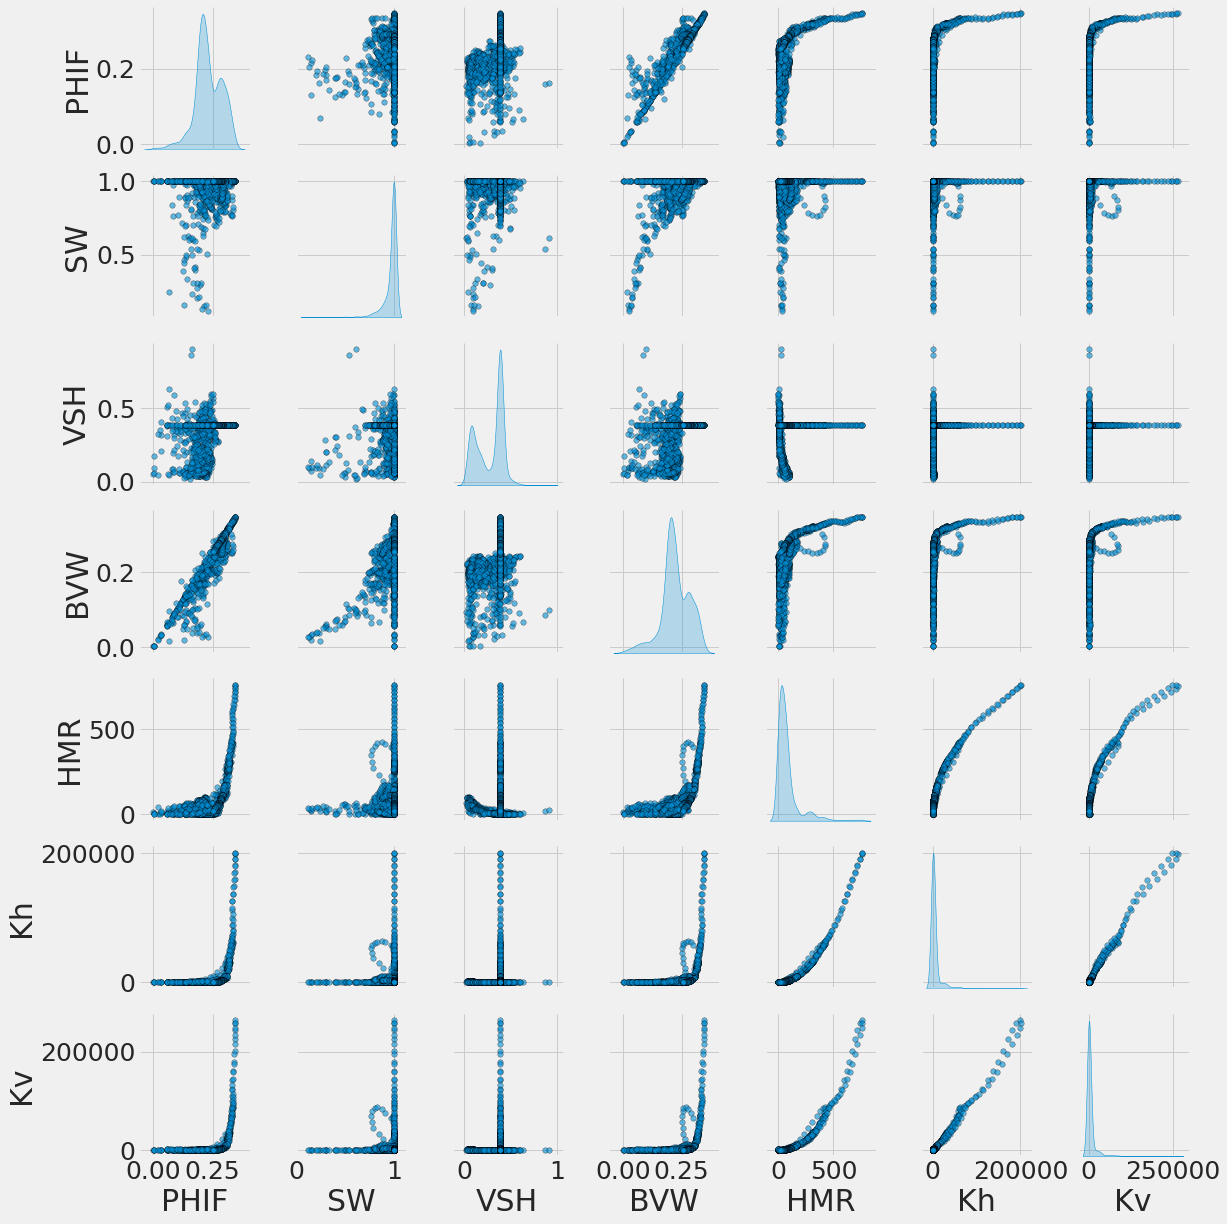

In [227]:
train_features = ['PHIF','SW','VSH','BVW','HMR','Kh', 'Kv']

sns.pairplot(well_train, vars=train_features, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

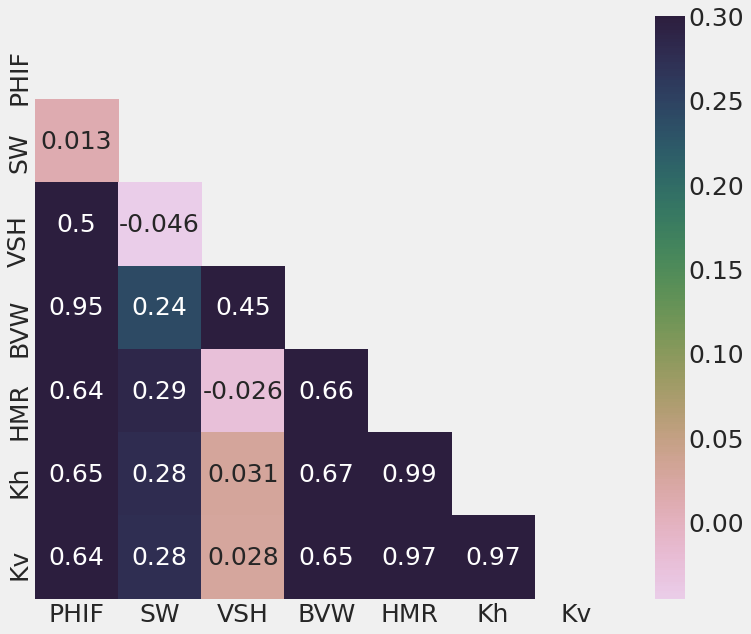

In [228]:
well_train_only_features = well_train[train_features]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(well_train_only_features.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True,)

plt.show()

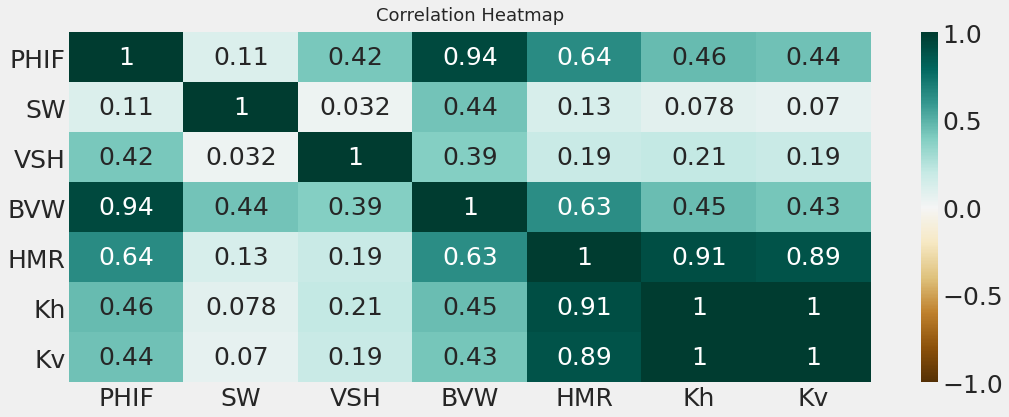

In [229]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(well_train_only_features.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

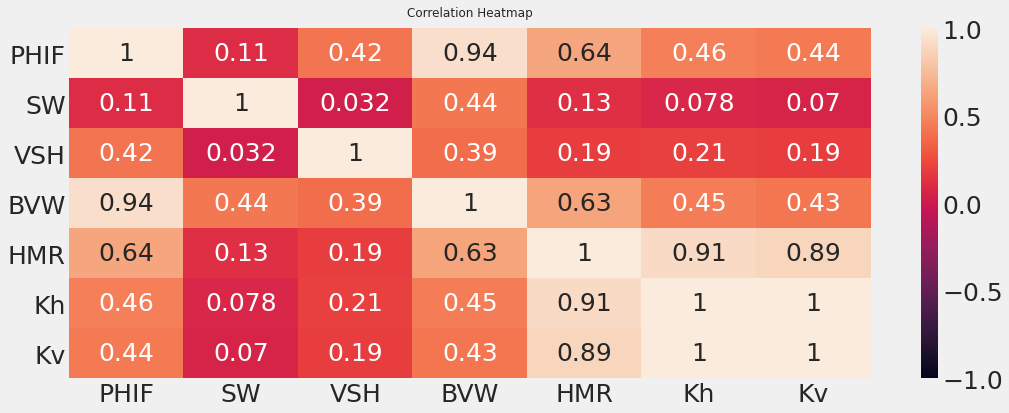

In [230]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(well_train_only_features.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#Step 4. Normalization

In [231]:
colnames = well_train.columns
only_feature = ['PHIF','SW','VSH','BVW', 'HMR', 'Kh'] # only feature column names
only_target = 'Kv' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['PHIF', 'SW', 'VSH', 'BVW', 'HMR', 'Kh', 'Kv', 'WELL', 'DEPTH'], dtype='object')

In [232]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

## ColumnTransformer
column_drop = ['WELL', 'DEPTH']
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=colnames)
well_train_norm

PHIF   SW   VSH   BVW   HMR    Kh    Kv         WELL   DEPTH
0    -0.75 0.67 -1.57 -0.58  0.00  0.13  0.18  15_9-19 BT2 4040.12
1    -0.90 0.67 -1.43 -0.72  0.13  0.20  0.26  15_9-19 BT2 4040.28
2    -0.84 0.67 -1.52 -0.66  0.23  0.25  0.32  15_9-19 BT2 4040.43
3    -0.65 0.67 -1.56 -0.48  0.33  0.30  0.36  15_9-19 BT2 4040.58
4    -0.72 0.67 -1.52 -0.55  0.41  0.34  0.41  15_9-19 BT2 4040.73
...    ...  ...   ...   ...   ...   ...   ...          ...     ...
1555  0.41 0.67  0.76  0.57 -0.17 -0.15 -0.17   15_9-19 SR 3799.33
1556  0.40 0.67  0.76  0.54 -0.26 -0.21 -0.23   15_9-19 SR 3799.48
1557  0.36 0.67  0.76  0.52 -0.36 -0.27 -0.29   15_9-19 SR 3799.64
1558  0.35 0.67  0.76  0.49 -0.45 -0.33 -0.36   15_9-19 SR 3799.79
1559  0.32 0.67  0.76  0.48 -0.56 -0.39 -0.44   15_9-19 SR 3799.94

[1560 rows x 9 columns]

In [233]:
wellnames = well_train_norm['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [234]:
x = well_train_norm[feature_target].astype(float)
y = well_train_norm['WELL'].astype(str)
z = well_train_norm['DEPTH'].astype(float)

well_train_norm = pd.concat([x, y, z], axis=1)

In [235]:
 #x = well_train_norm[feature_target].astype(float)
#sns.pairplot(well_train_norm, vars=feature_target, diag_kind = 'kde',
           # plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'm'})

In [236]:
plt.rcParams.update({'font.size': 17})

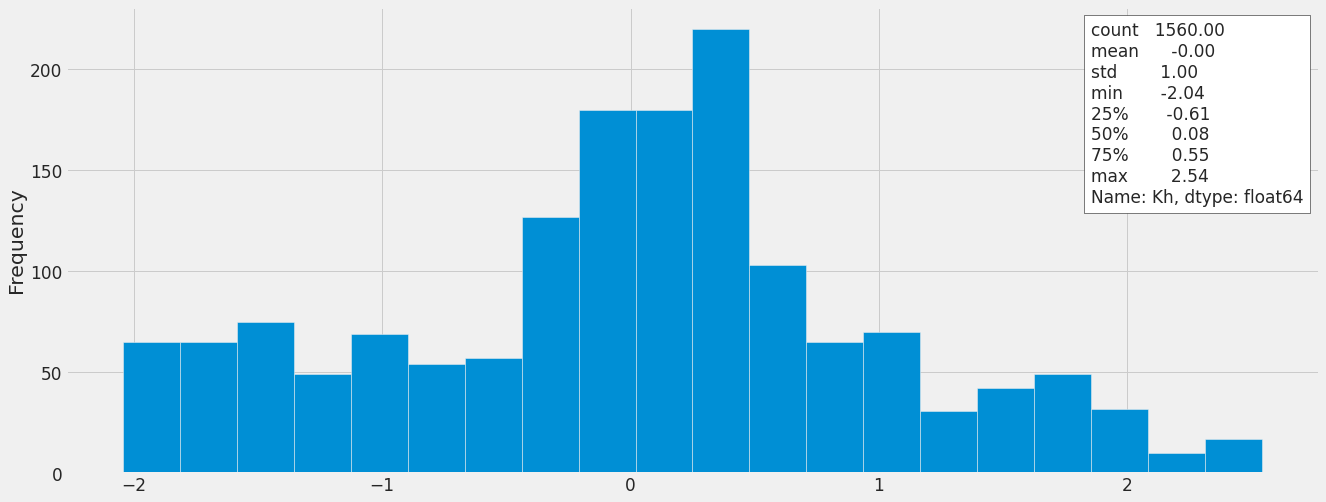

In [237]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(20,8))

well_train_norm['Kh'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train_norm['Kh'].describe()), loc=1)
ax.add_artist(anchored_text)

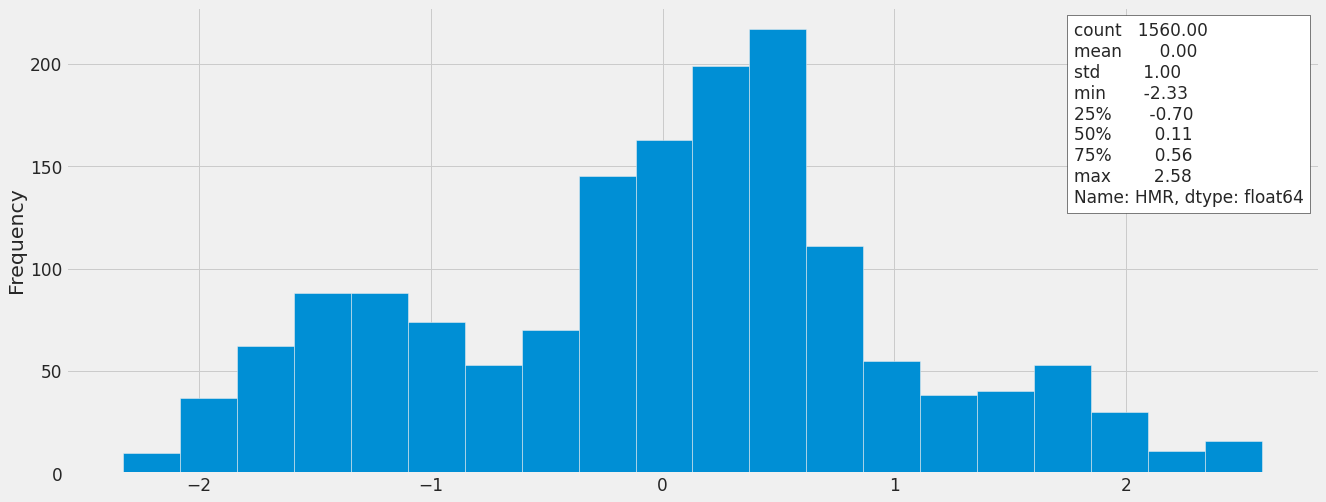

In [238]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(20,8))

well_train_norm['HMR'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train_norm['HMR'].describe()), loc=1)
ax.add_artist(anchored_text)

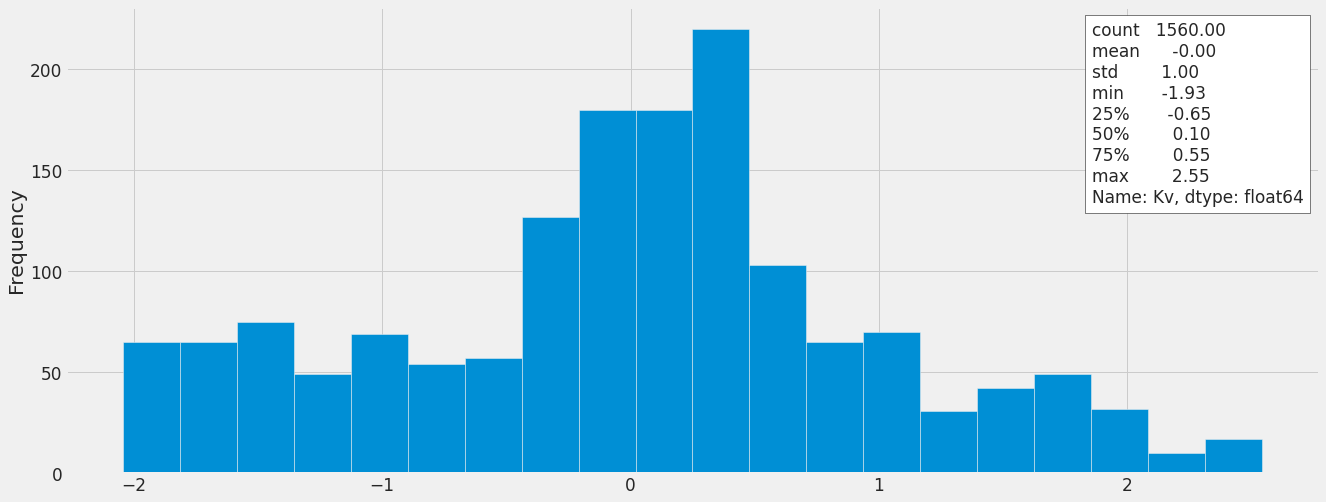

In [239]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(20,8))

well_train_norm['Kh'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train_norm['Kv'].describe()), loc=1)
ax.add_artist(anchored_text)

In [240]:
px.box(well_train_norm, x='HMR', orientation='h', points='all')

In [241]:
px.box(well_train_norm, x='Kv', orientation='h', points='all')

In [242]:
px.box(well_train_norm, x='Kh', orientation='h', points='all')

# Step 5. Removing Outliers

In [243]:
# make copy of well_train_norm, called well_train_dropped
well_train_drop = well_train_norm.copy()

# on the well_train_drop, drop WELL and DEPTH column
well_train_drop = well_train_norm.drop(['WELL', 'DEPTH'], axis=1)

In [244]:
well_train_drop.head()

PHIF   SW   VSH   BVW  HMR   Kh   Kv
0 -0.75 0.67 -1.57 -0.58 0.00 0.13 0.18
1 -0.90 0.67 -1.43 -0.72 0.13 0.20 0.26
2 -0.84 0.67 -1.52 -0.66 0.23 0.25 0.32
3 -0.65 0.67 -1.56 -0.48 0.33 0.30 0.36
4 -0.72 0.67 -1.52 -0.55 0.41 0.34 0.41

In [245]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Method 1: Standard Deviation Method (traditional)
well_train_std = well_train_drop[np.abs(well_train_drop - well_train_drop.mean()) <= (3 * well_train_drop.std())]

## delete all rows that have NaNs
well_train_std = well_train_std.dropna()

# Method 2: Isolation Forest
iso = IsolationForest(contamination=0.08)
yhat = iso.fit_predict(well_train_drop)
mask = yhat != -1
well_train_iso = well_train_norm[mask]

# Method 3: Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(well_train_drop)
mask = yhat != -1
well_train_ee = well_train_norm[mask]

# Method 4: Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(well_train_drop)
mask = yhat != -1
well_train_lof = well_train_norm[mask]

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_train_drop)
mask = yhat != -1
well_train_svm = well_train_norm[mask]

Number of points before outliers removed                       : 1560
Number of points after outliers removed with Isolation Forest  : 1435
Number of points after outliers removed with Outlier Factor    : 1092
Number of points after outliers removed with One-class SVM     : 1403
Number of points after outliers removed with Min. Covariance   : 1404
Number of points after outliers removed with Standard Deviation: 1553


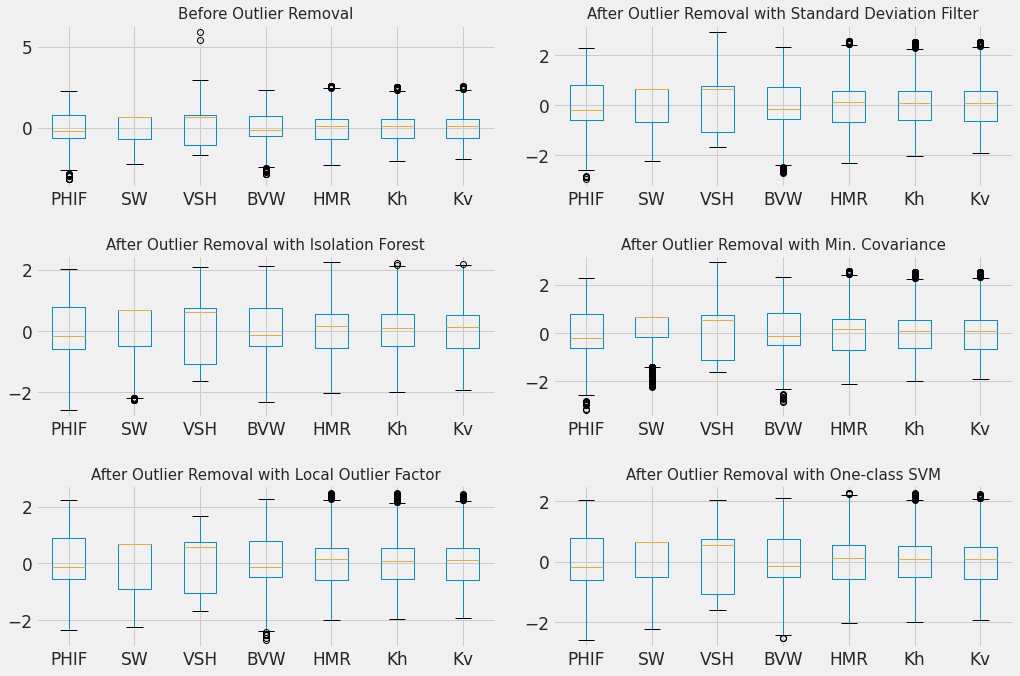

In [246]:
print('Number of points before outliers removed                       :', len(well_train_norm))
print('Number of points after outliers removed with Isolation Forest  :', len(well_train_iso))
print('Number of points after outliers removed with Outlier Factor    :', len(well_train_lof))
print('Number of points after outliers removed with One-class SVM     :', len(well_train_svm))
print('Number of points after outliers removed with Min. Covariance   :', len(well_train_ee))
print('Number of points after outliers removed with Standard Deviation:', len(well_train_std))

plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
well_train_norm[feature_target].boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(3,2,2)
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.subplot(3,2,4)
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

plt.subplot(3,2,5)
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

plt.subplot(3,2,6)
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

plt.tight_layout(1.7)
plt.show()

Text(0.5, 1.0, 'Before Outlier Removal')

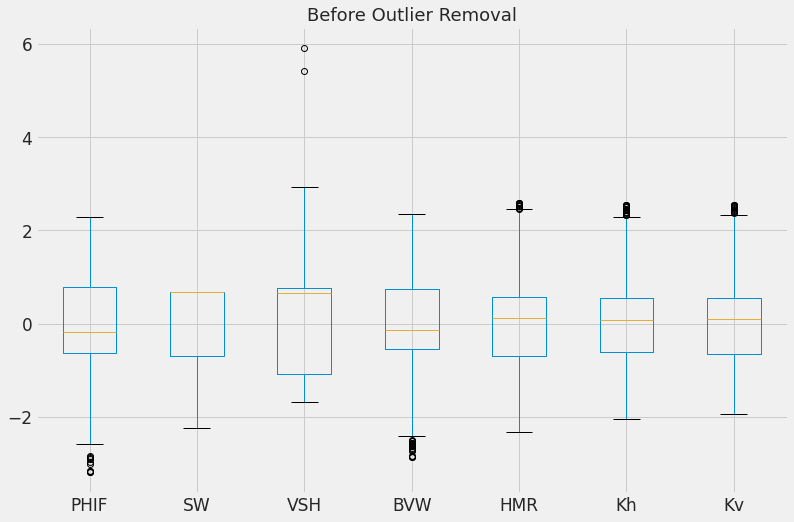

In [247]:
plt.figure(figsize=(12,8))
well_train_norm[feature_target].boxplot()
plt.title('Before Outlier Removal', size=18)

Text(0.5, 1.0, 'After Outlier Removal with Standard Deviation Filter')

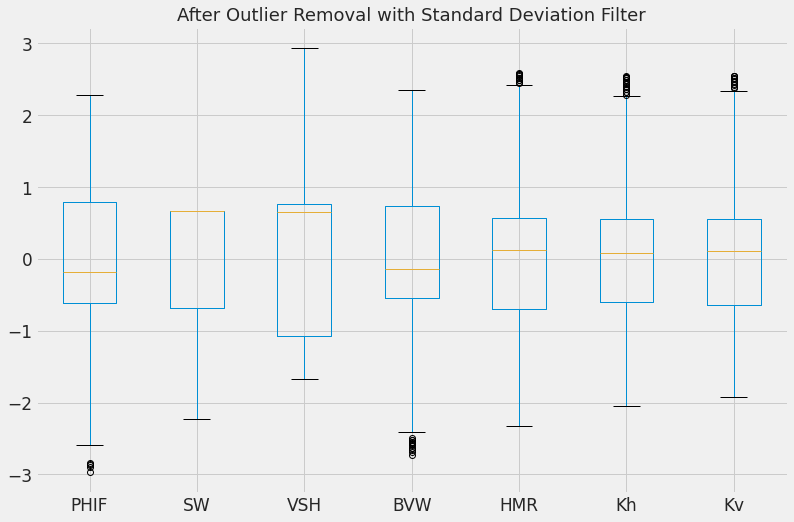

In [248]:
plt.figure(figsize=(12,8))
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=18)

Text(0.5, 1.0, 'After Outlier Removal with Isolation Forest')

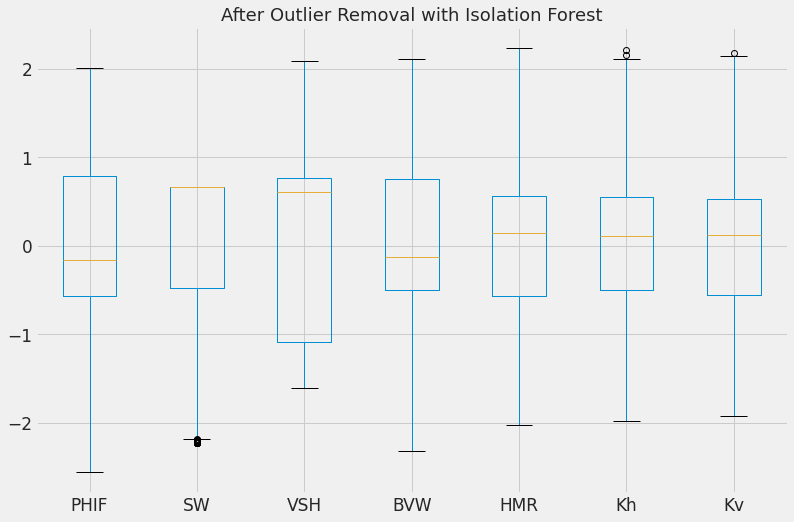

In [249]:
plt.figure(figsize=(12,8))
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=18)

Text(0.5, 1.0, 'After Outlier Removal with Min. Covariance')

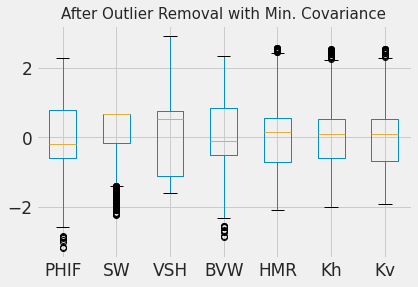

In [250]:
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

Text(0.5, 1.0, 'After Outlier Removal with Local Outlier Factor')

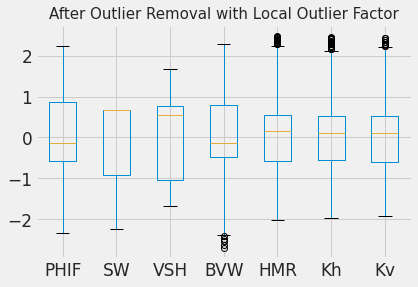

In [251]:
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

Text(0.5, 1.0, 'After Outlier Removal with One-class SVM')

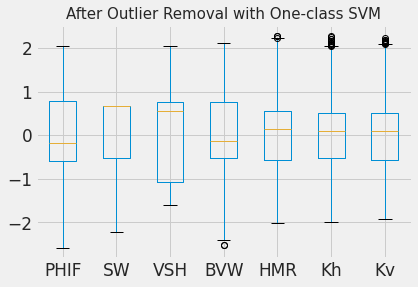

In [252]:
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

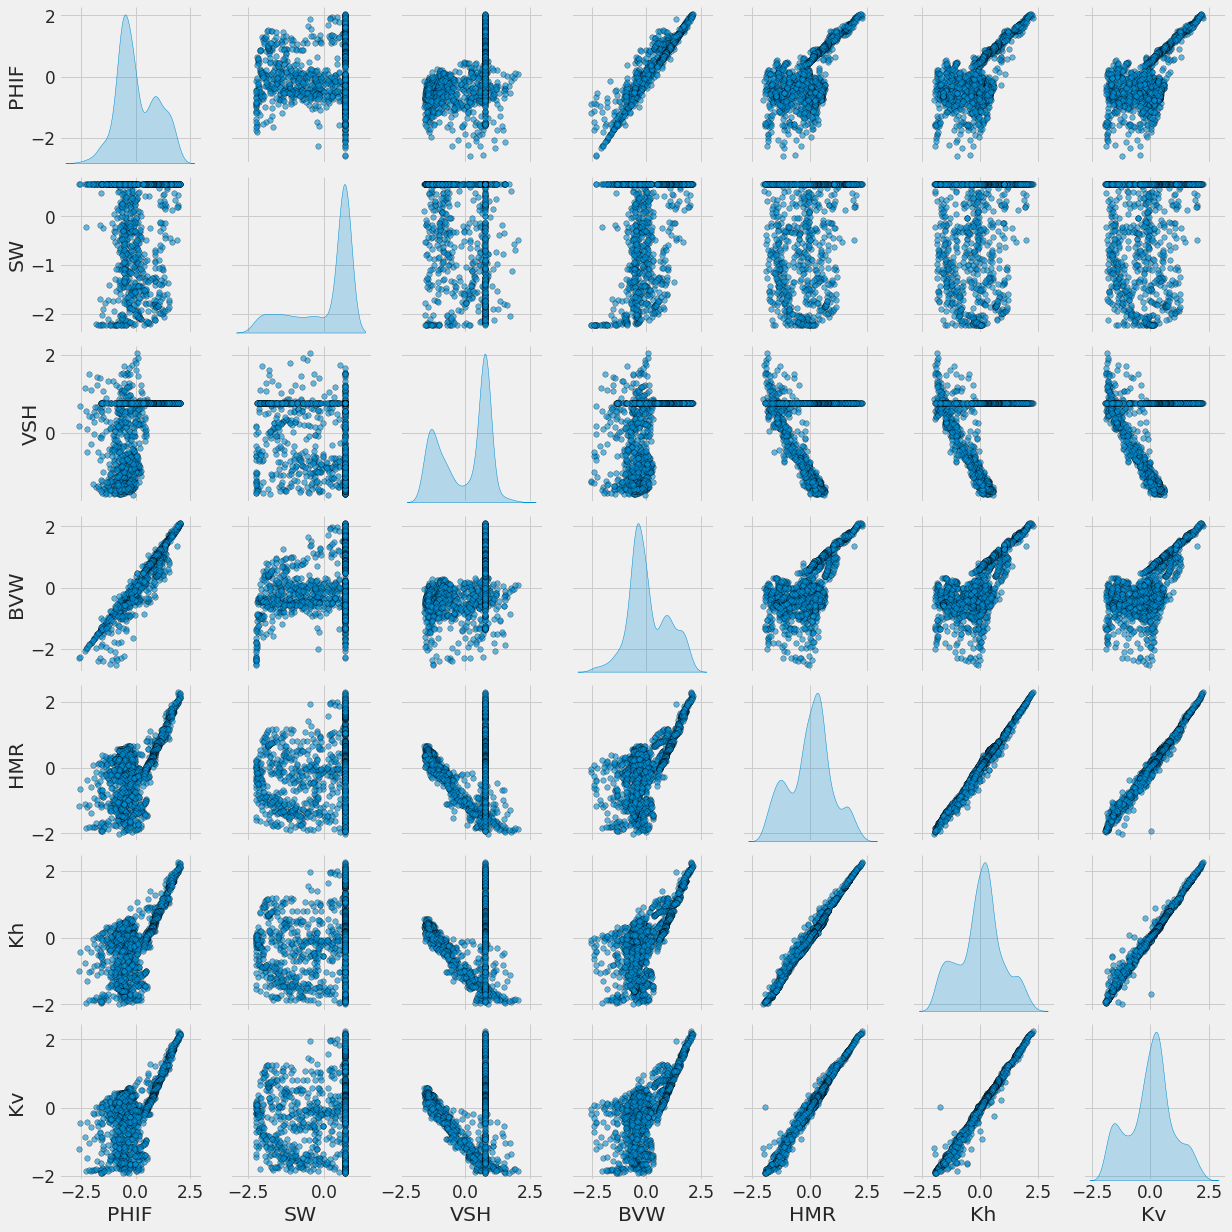

In [253]:
sns.pairplot(well_train_svm, vars=feature_target,
            diag_kind='kde',
            plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

# Step 6. Prediction! First Attempt

In [254]:
well_train_svm

PHIF   SW   VSH   BVW   HMR    Kh    Kv         WELL   DEPTH
0    -0.75 0.67 -1.57 -0.58  0.00  0.13  0.18  15_9-19 BT2 4040.12
1    -0.90 0.67 -1.43 -0.72  0.13  0.20  0.26  15_9-19 BT2 4040.28
2    -0.84 0.67 -1.52 -0.66  0.23  0.25  0.32  15_9-19 BT2 4040.43
3    -0.65 0.67 -1.56 -0.48  0.33  0.30  0.36  15_9-19 BT2 4040.58
4    -0.72 0.67 -1.52 -0.55  0.41  0.34  0.41  15_9-19 BT2 4040.73
...    ...  ...   ...   ...   ...   ...   ...          ...     ...
1555  0.41 0.67  0.76  0.57 -0.17 -0.15 -0.17   15_9-19 SR 3799.33
1556  0.40 0.67  0.76  0.54 -0.26 -0.21 -0.23   15_9-19 SR 3799.48
1557  0.36 0.67  0.76  0.52 -0.36 -0.27 -0.29   15_9-19 SR 3799.64
1558  0.35 0.67  0.76  0.49 -0.45 -0.33 -0.36   15_9-19 SR 3799.79
1559  0.32 0.67  0.76  0.48 -0.56 -0.39 -0.44   15_9-19 SR 3799.94

[1403 rows x 9 columns]

In [255]:
wellnames = well_train_svm['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [256]:
# Define the train data
feature = ['PHIF','SW','VSH','BVW', 'HMR','Kh']
target = 'Kv'

X_train = well_train_svm[only_feature].values
y_train = well_train_svm[only_target].values


In [257]:
only_feature

['PHIF', 'SW', 'VSH', 'BVW', 'HMR', 'Kh']

In [258]:
# Define the test data 
well_pred1 = well_train_norm.copy()

names_train = ['15_9-19 BT2', '15_9-19 SR']

X_test = []

y_test = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred1.loc[well_pred1['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  
  X_test.append(X_test_)
  y_test.append(y_test_)

# for each well 2 and 3
X_test1, X_test2 = X_test
y_test1, y_test2 = y_test

In [259]:
def reg_metrics(test, pred):
    '''Function returns basic metrics for regression models'''
    print('Mean Absolute Error:', metrics.mean_absolute_error(test, pred))
    print('Mean Squared Error:', metrics.mean_squared_error(test, pred))
    print('Root Mean Squared Error:', np.sqrt(
        metrics.mean_squared_error(test, pred)))
    print('R Squared:', (metrics.r2_score(test, pred)))

def reg_plot(test, pred):
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()

# calculate aic for regression
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic

R-squared of Well 2: 0.9812967439662278
RMSE of Well 2: 0.10322482643769675


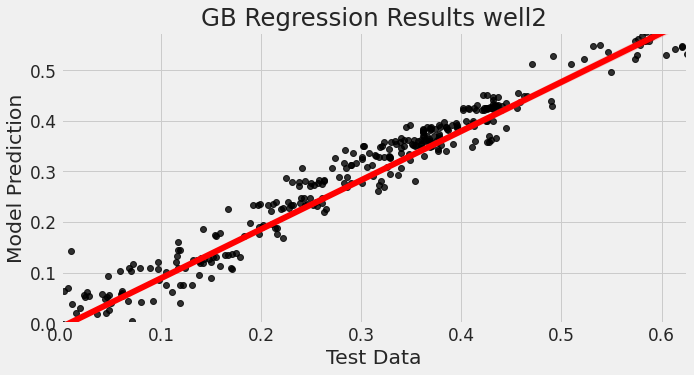

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.9413465022219497
RMSE of Well 3: 0.23757544494476548


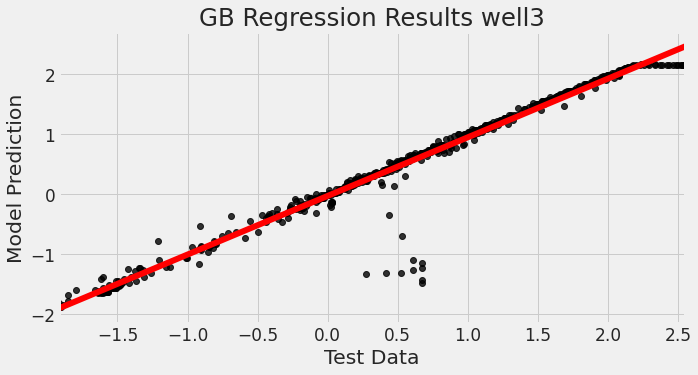

In [260]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Create the regressor
model = GradientBoostingRegressor()
# print(model)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Predict on well 2
y_pred1 = model.predict(X_test1)
#reg_metrics(y_test1, y_pred1)
print("R-squared of Well 2: {}".format(model.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('GB Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1, y_pred1)
# Predict on well 3
y_pred2 = model.predict(X_test2)
print("R-squared of Well 3: {}".format(model.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    #plt.xlim(0, max(test))
    #plt.ylim(0, max(pred))
    plt.title('GB Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
     
    plt.show()
reg_plot(y_test2, y_pred2)

In [261]:
print("test accuracy of well 2")
reg_metrics(y_test1, y_pred1)

print("test accuracy of well 3")
reg_metrics(y_test2, y_pred2)

test accuracy of well 2
Mean Absolute Error: 0.05207493378294777
Mean Squared Error: 0.010655364793092618
Root Mean Squared Error: 0.10322482643769675
R Squared: 0.9812967439662278
test accuracy of well 3
Mean Absolute Error: 0.068852167139168
Mean Squared Error: 0.0564420920407033
Root Mean Squared Error: 0.23757544494476548
R Squared: 0.9413465022219497


In [262]:
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
scores

array([0.96701091, 0.98532977, 0.961834  , 0.89009481, 0.89694073])

In [263]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.94 accuracy with a standard deviation of 0.04


R-squared of Well 2: 0.9765963137698885
RMSE of Well 2: 0.11546960635303406


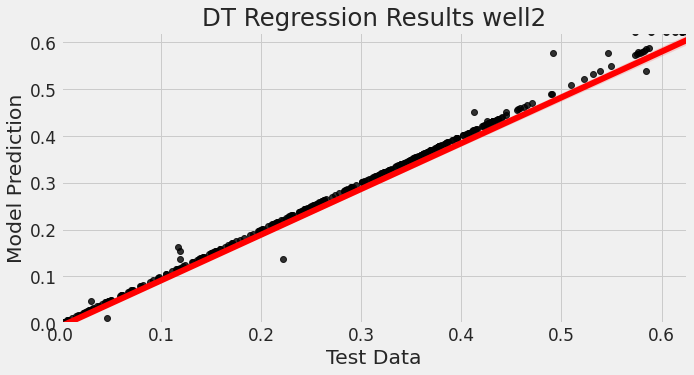

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.9391628521258413
RMSE of Well 3: 0.24195745956918402


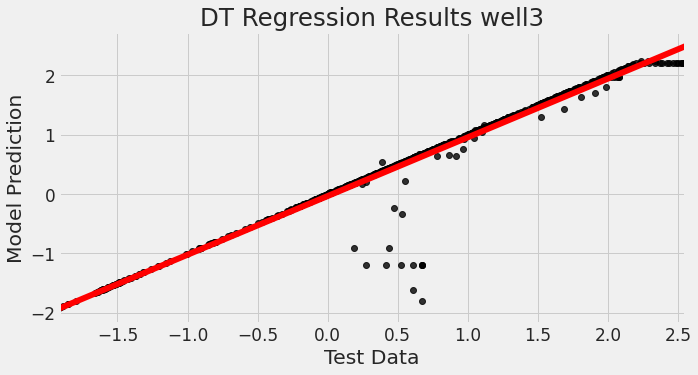

In [264]:
# 3. Decision Tree - Regression
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
# Prediction on test data
y_pred1 = dt_reg.predict(X_test1)
print("R-squared of Well 2: {}".format(dt_reg.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('DT Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1, y_pred1)
# Predict on well 3
y_pred2 = dt_reg.predict(X_test2)
print("R-squared of Well 3: {}".format(dt_reg.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    #plt.xlim(0, max(test))
    #plt.ylim(0, max(pred))
    plt.title('DT Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2, y_pred2)



In [265]:
print("test accuracy of well 2")
reg_metrics(y_test1, y_pred1)

print("test accuracy of well 3")
reg_metrics(y_test2, y_pred2)

test accuracy of well 2
Mean Absolute Error: 0.020933293966548756
Mean Squared Error: 0.013333229991324646
Root Mean Squared Error: 0.11546960635303406
R Squared: 0.9765963137698885
test accuracy of well 3
Mean Absolute Error: 0.04287721009586384
Mean Squared Error: 0.05854341224117332
Root Mean Squared Error: 0.24195745956918402
R Squared: 0.9391628521258413


In [266]:
scores = cross_val_score(dt_reg, X_train, y_train, scoring='r2', cv=5)
scores 

array([0.90162168, 0.98132355, 0.93950057, 0.88066153, 0.87322781])

In [267]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.92 accuracy with a standard deviation of 0.04


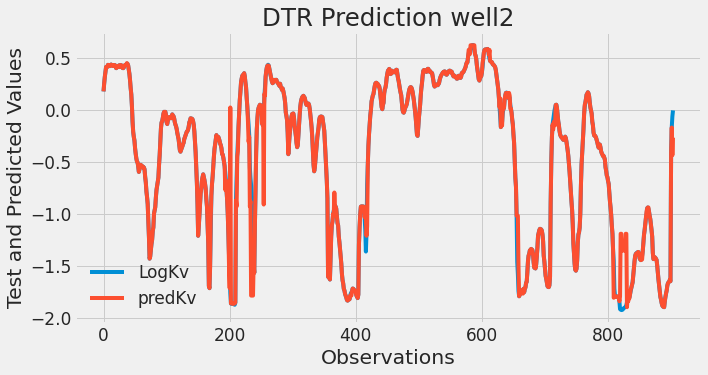

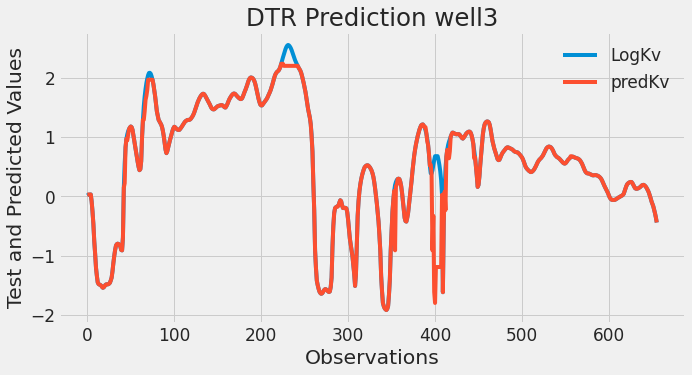

In [268]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot(y_pred1,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('DTR Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

#############

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('DTR Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()


-0.022263434069991993
[ 0.21505248  0.02723249 -0.03753078 -0.15348167  0.35606652  0.60654268]
R-squared of Well 2: 0.9741269930920775
RMSE of Well 2: 0.12140847500180858


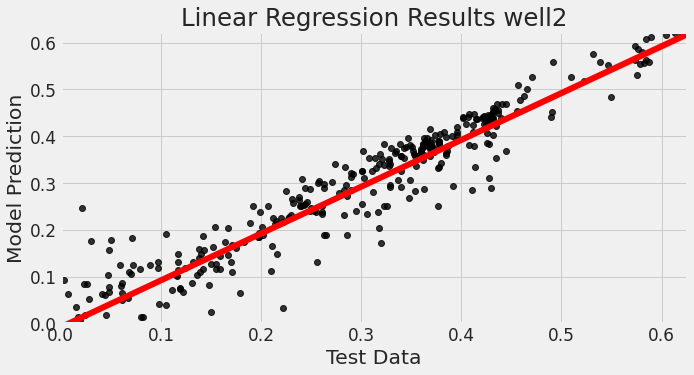

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.8844507871989457
RMSE of Well 3: 0.3334556564179299


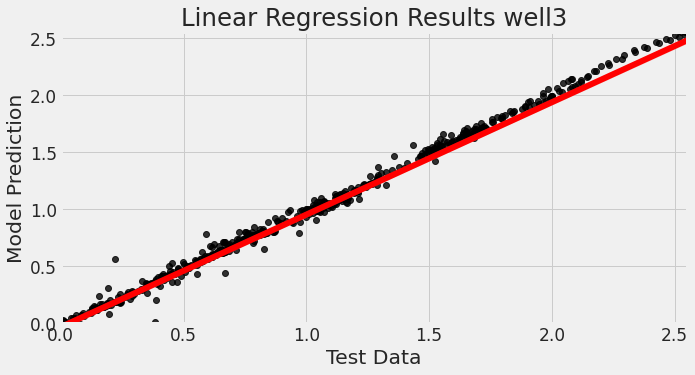

In [269]:
# 1. MLR - Multi Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)  # training the algorithm
print(lin_reg.intercept_)  # intercept
print(lin_reg.coef_)  # coefficients
# Prediction on test data
y_pred_lin = lin_reg.predict(X_test1)
print("R-squared of Well 2: {}".format(lin_reg.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred_lin))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Linear Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1,y_pred_lin)
# Predict on well 3
y_pred_lin2 = lin_reg.predict(X_test2)
print("R-squared of Well 3: {}".format(lin_reg.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred_lin2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Linear Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2,  y_pred_lin2)



In [270]:
print(lin_reg) 
print(lin_reg.coef_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[ 0.21505248  0.02723249 -0.03753078 -0.15348167  0.35606652  0.60654268]


In [271]:
print("test accuracy of well 2")
reg_metrics(y_test1, y_pred1)

print("test accuracy of well 3")
reg_metrics(y_test2, y_pred2)

test accuracy of well 2
Mean Absolute Error: 0.020933293966548756
Mean Squared Error: 0.013333229991324646
Root Mean Squared Error: 0.11546960635303406
R Squared: 0.9765963137698885
test accuracy of well 3
Mean Absolute Error: 0.04287721009586384
Mean Squared Error: 0.05854341224117332
Root Mean Squared Error: 0.24195745956918402
R Squared: 0.9391628521258413


In [272]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores 

array([0.96860587, 0.98784606, 0.96108642, 0.98997783, 0.90656859])

In [273]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.96 accuracy with a standard deviation of 0.03


In [274]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,8))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)   

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [275]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0           0.01          0.00  ...              0.98             0.00
1           0.01          0.00  ...              0.99             0.00
2           0.00          0.00  ...              0.99             0.00
3           0.00          0.00  ...              0.99             0.00
4           0.00          0.00  ...              0.99             0.00
5           0.00          0.00  ...              0.99             0.00
6           0.00          0.00  ...              0.99             0.00

[7 rows x 21 columns]

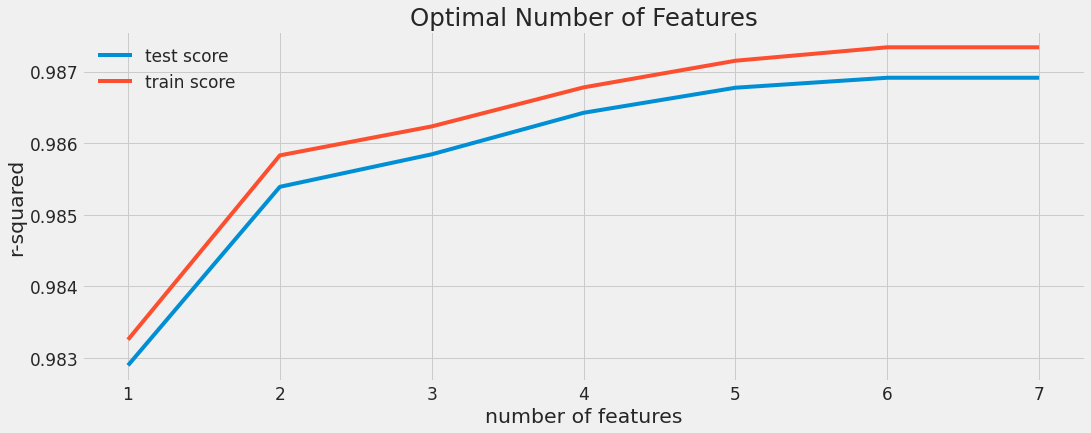

In [276]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [277]:
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic

In [278]:
num_params = len(lin_reg.coef_) + 1
print('Number of parameters: %d' % (num_params))

Number of parameters: 7


In [279]:
from math import log
mse = mean_squared_error(y_test2, y_pred_lin2)
mse

0.11119267479711252

In [280]:
aic = calculate_aic(len(y), mse, num_params)
print('AIC: %.3f' % aic)

AIC: -3412.526


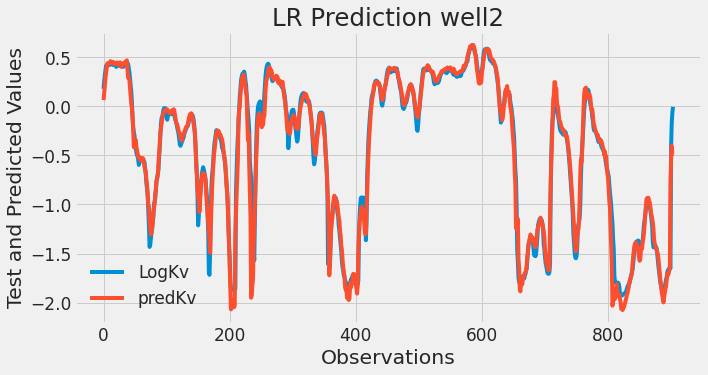

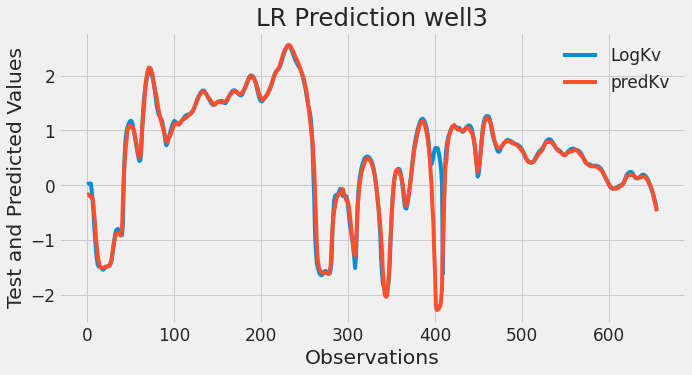

In [281]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot( y_pred_lin,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('LR Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

########################

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred_lin2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('LR Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

R-squared of Well 2: 0.9870324135461074
RMSE of Well 2: 0.0859518300290356


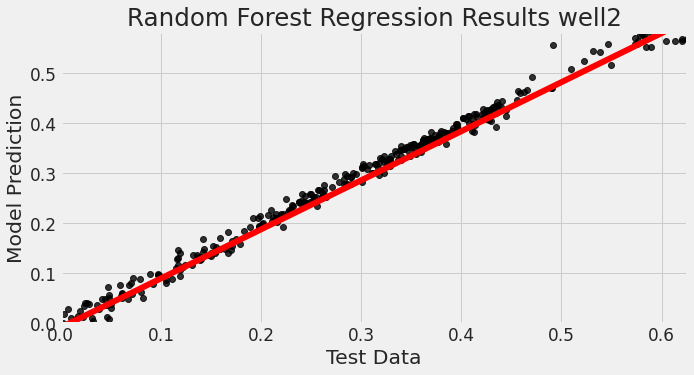

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.9444458325918031
RMSE of Well 3: 0.3334556564179299


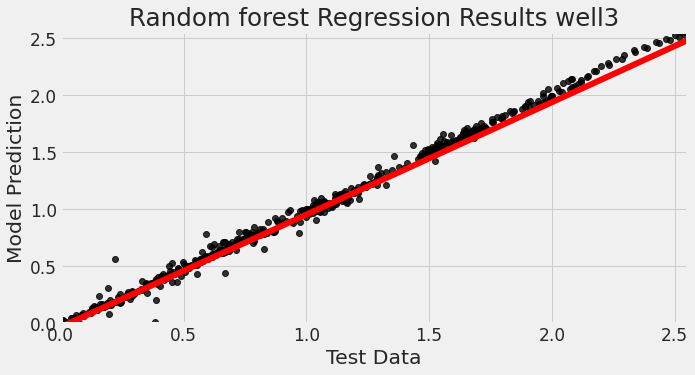

In [282]:
# 4. Random Forest - Regression
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
# Prediction on test data
y_pred1 = rf_reg.predict(X_test1)
print("R-squared of Well 2: {}".format(rf_reg.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Random Forest Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1, y_pred1)
# Predict on well 3
y_pred2 = lin_reg.predict(X_test2)
print("R-squared of Well 3: {}".format(rf_reg.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Random forest Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2, y_pred2)



In [283]:
print("test accuracy of well 2")
reg_metrics(y_test1, y_pred1)

print("test accuracy of well 3")
reg_metrics(y_test2, y_pred2)

test accuracy of well 2
Mean Absolute Error: 0.030554169006504997
Mean Squared Error: 0.0073877170853402264
Root Mean Squared Error: 0.0859518300290356
R Squared: 0.9870324135461074
test accuracy of well 3
Mean Absolute Error: 0.08631025803196488
Mean Squared Error: 0.11119267479711252
Root Mean Squared Error: 0.3334556564179299
R Squared: 0.8844507871989458


In [284]:
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
scores   

array([0.96705681, 0.98537881, 0.962904  , 0.89009481, 0.89694982])

In [285]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.94 accuracy with a standard deviation of 0.04


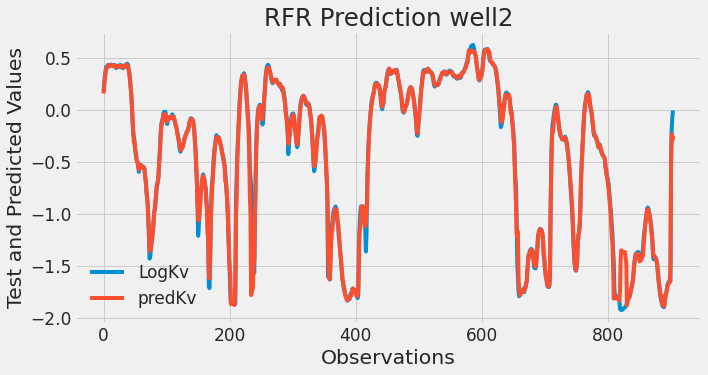

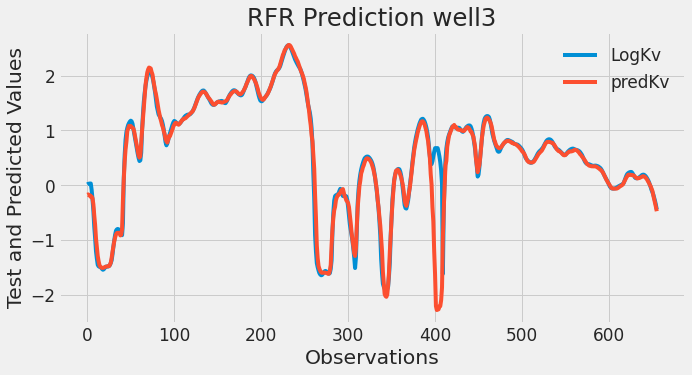

In [286]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot(y_pred1,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('RFR Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

#############

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('RFR Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

In [287]:
from sklearn.tree import export_graphviz
import pydot

In [288]:
tree = rf_reg.estimators_[5]

In [289]:
export_graphviz(tree, out_file = 'tree.dot', feature_names = only_feature, rounded = True, precision = 1)

In [290]:
(graph, ) = pydot.graph_from_dot_file('tree.dot')

In [291]:
graph.write_png('tree.png')


In [292]:
#X = well_train_svm[only_feature].values
#y = well_train_svm[only_target].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [293]:
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
#print('Shape of Test X:', X_test.shape)
#print('Shape of Test y:', y_test.shape)

Shape of Training X: (1403, 6)
Shape of Training y: (1403,)


Epoch 1/20
33/33 [==============================] - 1s 5ms/step - loss: 0.6701 - mse: 0.6701 - val_loss: 0.2263 - val_mse: 0.2263
Epoch 2/20
33/33 [==============================] - 0s 2ms/step - loss: 0.5139 - mse: 0.5139 - val_loss: 0.1481 - val_mse: 0.1481
Epoch 3/20
33/33 [==============================] - 0s 2ms/step - loss: 0.4025 - mse: 0.4025 - val_loss: 0.1019 - val_mse: 0.1019
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 0.3086 - mse: 0.3086 - val_loss: 0.0804 - val_mse: 0.0804
Epoch 5/20
33/33 [==============================] - 0s 2ms/step - loss: 0.2374 - mse: 0.2374 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 6/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1855 - mse: 0.1855 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 7/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1457 - mse: 0.1457 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 8/20
33/33 [==============================] - 0s 2ms/step - loss: 0.1124 - mse: 0.11

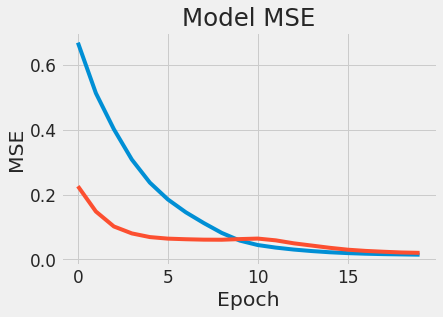

In [294]:
def build_model():
    ann_reg = keras.Sequential([
        layers.Dense(5, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1) ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    ann_reg.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return ann_reg

ann_reg = build_model()
#ann_reg.summary()

history = ann_reg.fit(X_train, y_train, epochs=20, validation_split=0.25, verbose=1)
print(history.history.keys())
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

y_pred_ann1 = ann_reg.predict(X_test1).flatten()
y_pred_ann2 = ann_reg.predict(X_test2).flatten()
# Regression Plot - ANN
#reg_plot(y_test1, y_pred_ann1)
#scatter_plot_comparison(y_test, y_pred_ann)
# Metrics for ANN
reg_metrics(y_test1, y_pred_ann1)

In [295]:
y_pred_ann2 = ann_reg.predict(X_test2).flatten()

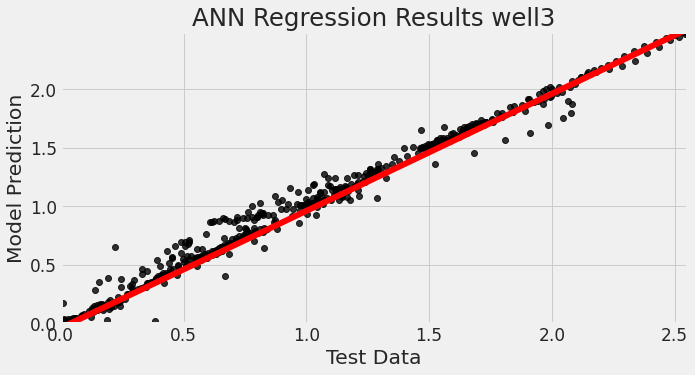

In [296]:
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('ANN Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2, y_pred_ann2)

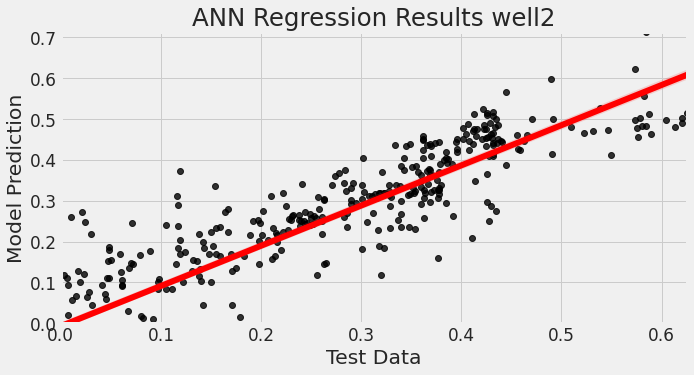

In [297]:
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('ANN Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test1, y_pred_ann1)

In [298]:
#reg_plot(y_test2, y_pred_ann2)
reg_metrics(y_test2, y_pred_ann2)

Mean Absolute Error: 0.10424073297087469
Mean Squared Error: 0.10078640283275922
Root Mean Squared Error: 0.31746874307994355
R Squared: 0.8952647777416567


In [299]:
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
scores   

array([0.96710677, 0.98543046, 0.96153178, 0.89046202, 0.89626771])

In [300]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.94 accuracy with a standard deviation of 0.04


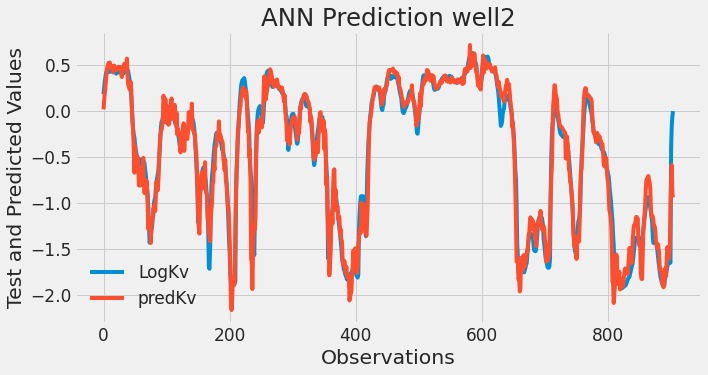

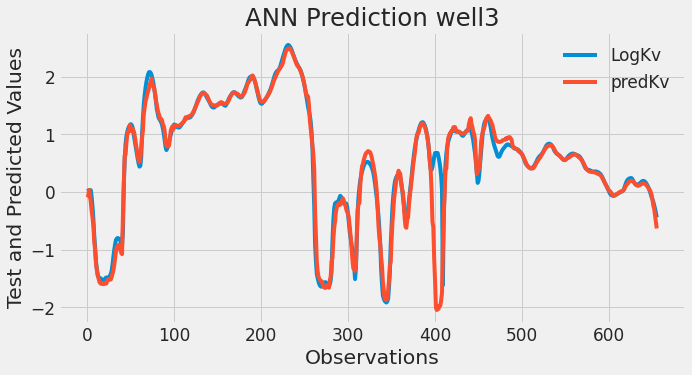

In [301]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot(y_pred_ann1,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('ANN Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

#############

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred_ann2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('ANN Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

In [302]:
ann_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [303]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test1, y_pred1 = scaler.inverse_transform(y_test1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test2, y_pred2 = scaler.inverse_transform(y_test2.reshape(-1,1)), scaler.inverse_transform(y_pred2.reshape(-1,1))


In [304]:
w1 = np.arange(4040,4180, (140/904))

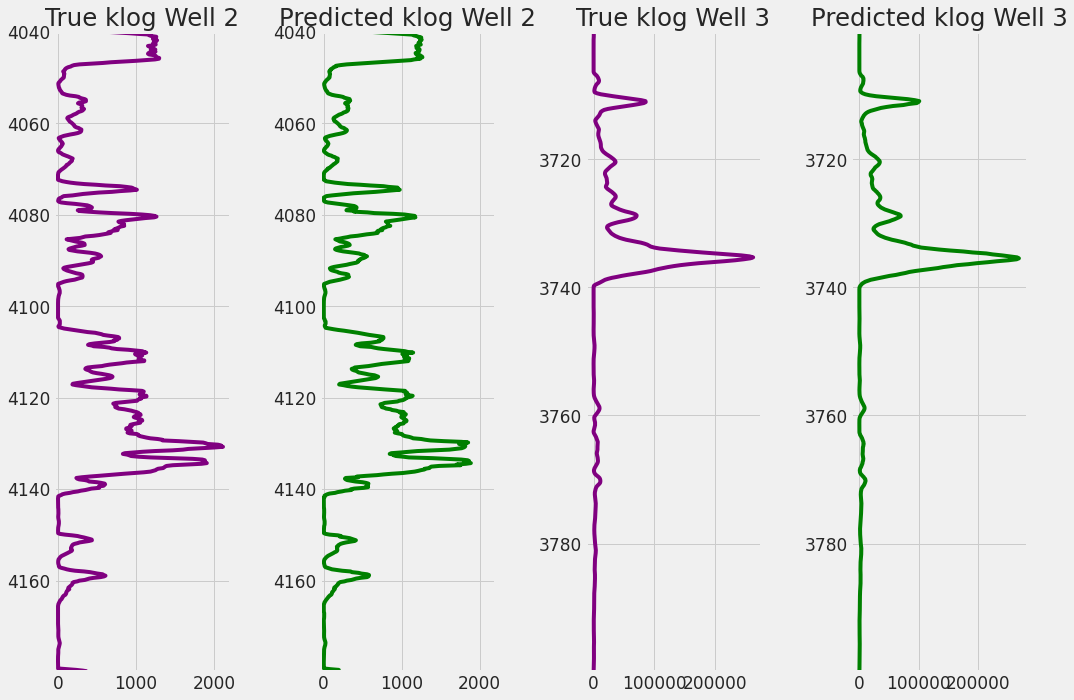

<Figure size 432x288 with 0 Axes>

In [305]:

x = [y_test1, y_pred1, y_test2, y_pred2]
y = [w1, w1, well3['DEPTH'], well3['DEPTH']]

color = ['purple', 'green', 'purple', 'green']
title = ['True klog Well 2', 'Predicted klog Well 2', 'True klog Well 3', 'Predicted klog Well 3']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[0].set_xlim(-50, 2200)
  ax[1].set_xlim(-50, 2200)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout(1)

plt.show()
plt.savefig('final.png', dpi=300)

In [306]:
plt.savefig('final_track_plot11.png', dpi=300)

<Figure size 432x288 with 0 Axes>

# Step 7. Decision Trees for Final Prediction

In [307]:
# Define the X and y from the SVM normalized dataset
X = well_train_svm[only_feature].values
y = well_train_svm[only_target].values

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [308]:
model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [10, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
model_random.best_params_

{'max_depth': 10, 'n_estimators': 1000}

In [309]:
y_pred_ht = model_random.predict(X_test)

print("R-squared: {}".format(rf_reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ht))
print("RMSE: {}".format(rmse))

R-squared: 0.9973812877047125
RMSE: 0.1250247749863178


In [310]:
well_pred

PHIF   SW  VSH  BVW  KLOGH       WELL   DEPTH
1040  0.14 0.33 0.16 0.05  55.93  15_9-19 A 3825.09
1041  0.15 0.30 0.14 0.05  87.22  15_9-19 A 3825.24
1042  0.16 0.29 0.13 0.04 118.74  15_9-19 A 3825.39
1043  0.16 0.28 0.13 0.04 118.14  15_9-19 A 3825.54
1044  0.16 0.27 0.12 0.04 134.62  15_9-19 A 3825.70
...    ...  ...  ...  ...    ...        ...     ...
1658  0.12 0.52 0.24 0.06   6.87  15_9-19 A 3919.27
1659  0.09 0.69 0.18 0.06  11.51  15_9-19 A 3919.42
1660  0.15 0.48 0.18 0.07  42.22  15_9-19 A 3919.58
1661  0.23 0.36 0.25 0.08  36.27  15_9-19 A 3919.73
1662  0.13 0.56 0.25 0.07   5.17  15_9-19 A 3919.88

[623 rows x 7 columns]

In [311]:
well_pred.rename(columns = {'KLOGH':'Kh'}, inplace = True)

In [312]:
#well_pred.to_excel('/content/wellpred.xlsx', index=False)
#well_pred = pd.read_excel("/content/sample_data/well_pred.xlsx")

In [313]:
well_pred.insert(4,'HMR', well_pred['Kh'].values/well_pred['PHIF'].values,True)
well_pred.describe()

PHIF     SW    VSH    BVW     HMR      Kh   DEPTH
count 623.00 623.00 623.00 623.00  623.00  623.00  623.00
mean    0.19   0.25   0.16   0.04     inf  754.72 3872.48
std     0.05   0.14   0.09   0.01     nan 1448.17   27.43
min     0.00   0.04   0.02   0.00    0.51    0.10 3825.09
25%     0.17   0.18   0.09   0.03  151.04   29.19 3848.79
50%     0.21   0.23   0.17   0.04  572.04  111.23 3872.48
75%     0.23   0.27   0.22   0.05 3291.50  650.68 3896.18
max     0.28   1.00   0.48   0.08     inf 7899.63 3919.88

In [314]:
a = np.sqrt(well_pred[['HMR']].sum(axis=1))
a
cols = ['HMR']
hmr = pd.DataFrame(a, columns=cols)

well_pred['HMR'] = hmr['HMR'].values

well_pred.describe()

PHIF     SW    VSH    BVW    HMR      Kh   DEPTH
count 623.00 623.00 623.00 623.00 623.00  623.00  623.00
mean    0.19   0.25   0.16   0.04    inf  754.72 3872.48
std     0.05   0.14   0.09   0.01    nan 1448.17   27.43
min     0.00   0.04   0.02   0.00   0.72    0.10 3825.09
25%     0.17   0.18   0.09   0.03  12.29   29.19 3848.79
50%     0.21   0.23   0.17   0.04  23.92  111.23 3872.48
75%     0.23   0.27   0.22   0.05  57.37  650.68 3896.18
max     0.28   1.00   0.48   0.08    inf 7899.63 3919.88

In [315]:
# Replacing infinite with nan
well_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
well_pred.dropna(inplace=True)
  
# Printing df
well_pred.describe()

PHIF     SW    VSH    BVW    HMR      Kh   DEPTH
count 619.00 619.00 619.00 619.00 619.00  619.00  619.00
mean    0.19   0.24   0.16   0.04  40.56  759.60 3872.59
std     0.05   0.13   0.09   0.01  41.90 1451.57   27.48
min     0.00   0.04   0.02   0.00   0.72    0.10 3825.09
25%     0.18   0.18   0.09   0.04  12.22   29.95 3848.63
50%     0.21   0.23   0.17   0.04  23.90  113.42 3872.79
75%     0.23   0.27   0.22   0.05  56.52  651.70 3896.33
max     0.28   1.00   0.48   0.08 182.52 7899.63 3919.88

In [316]:
well_pred.to_csv('/content/sample_data/sama.csv', index=False)

In [317]:
depth = well_pred['DEPTH'].values
only_feature


['PHIF', 'SW', 'VSH', 'BVW', 'HMR', 'Kh']

In [318]:
only_feature = ['PHIF',	'SW',	'VSH',	'BVW',	'HMR',	'Kh']

In [319]:
well_1 = well_pred[only_feature].values
well_1

array([[1.44541000e-01, 3.27000000e-01, 1.56524000e-01, 4.67570000e-02,
        1.96702463e+01, 5.59256000e+01],
       [1.52656000e-01, 3.01800000e-01, 1.42291000e-01, 4.58230000e-02,
        2.39033253e+01, 8.72229000e+01],
       [1.55366000e-01, 2.87000000e-01, 1.29816000e-01, 4.45030000e-02,
        2.76449246e+01, 1.18737200e+02],
       ...,
       [1.52183000e-01, 4.83500000e-01, 1.76883000e-01, 7.01570000e-02,
        1.66561650e+01, 4.22198000e+01],
       [2.30502000e-01, 3.62400000e-01, 2.53825000e-01, 8.03450000e-02,
        1.25446336e+01, 3.62736000e+01],
       [1.25282000e-01, 5.64500000e-01, 2.54320000e-01, 6.66880000e-02,
        6.42306213e+00, 5.16860000e+00]])

In [320]:
# Normalize X_test of well 1
well_1 = scaler.fit_transform(well_1)

# Predict to well 1

well1_pred = dt_reg.predict(well_1)

# Denormalize y_pred of well 1
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
well1_pred = scaler.inverse_transform(well1_pred.reshape(-1,1))


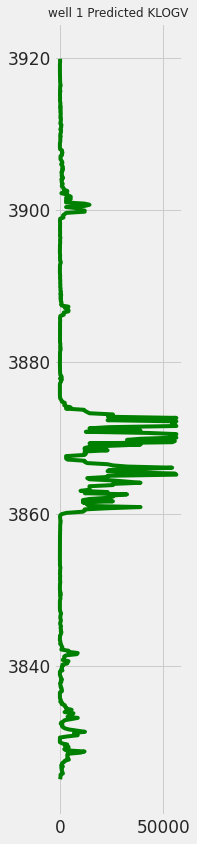

In [321]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(well1_pred, depth, color='green')
plt.title('well 1 Predicted KLOGV', size=12)
plt.tight_layout(1)
plt.show()

In [322]:
well_pred['Kv'] = well1_pred 
well_pred

PHIF   SW  VSH  BVW   HMR     Kh       WELL   DEPTH     Kv
1040  0.14 0.33 0.16 0.05 19.67  55.93  15_9-19 A 3825.09  81.88
1041  0.15 0.30 0.14 0.05 23.90  87.22  15_9-19 A 3825.24 192.65
1042  0.16 0.29 0.13 0.04 27.64 118.74  15_9-19 A 3825.39 309.98
1043  0.16 0.28 0.13 0.04 27.57 118.14  15_9-19 A 3825.54 309.98
1044  0.16 0.27 0.12 0.04 29.38 134.62  15_9-19 A 3825.70 304.53
...    ...  ...  ...  ...   ...    ...        ...     ...    ...
1658  0.12 0.52 0.24 0.06  7.43   6.87  15_9-19 A 3919.27  47.33
1659  0.09 0.69 0.18 0.06 11.35  11.51  15_9-19 A 3919.42  44.44
1660  0.15 0.48 0.18 0.07 16.66  42.22  15_9-19 A 3919.58 105.80
1661  0.23 0.36 0.25 0.08 12.54  36.27  15_9-19 A 3919.73  89.45
1662  0.13 0.56 0.25 0.07  6.42   5.17  15_9-19 A 3919.88   7.31

[619 rows x 9 columns]

In [323]:
c = ['DEPTH'	,'PHIF',	'SW',	'VSH','BVW',	'HMR',	'Kh', 'Kv']
final_pred = well_pred[c]
final_pred

DEPTH  PHIF   SW  VSH  BVW   HMR     Kh     Kv
1040 3825.09  0.14 0.33 0.16 0.05 19.67  55.93  81.88
1041 3825.24  0.15 0.30 0.14 0.05 23.90  87.22 192.65
1042 3825.39  0.16 0.29 0.13 0.04 27.64 118.74 309.98
1043 3825.54  0.16 0.28 0.13 0.04 27.57 118.14 309.98
1044 3825.70  0.16 0.27 0.12 0.04 29.38 134.62 304.53
...      ...   ...  ...  ...  ...   ...    ...    ...
1658 3919.27  0.12 0.52 0.24 0.06  7.43   6.87  47.33
1659 3919.42  0.09 0.69 0.18 0.06 11.35  11.51  44.44
1660 3919.58  0.15 0.48 0.18 0.07 16.66  42.22 105.80
1661 3919.73  0.23 0.36 0.25 0.08 12.54  36.27  89.45
1662 3919.88  0.13 0.56 0.25 0.07  6.42   5.17   7.31

[619 rows x 8 columns]

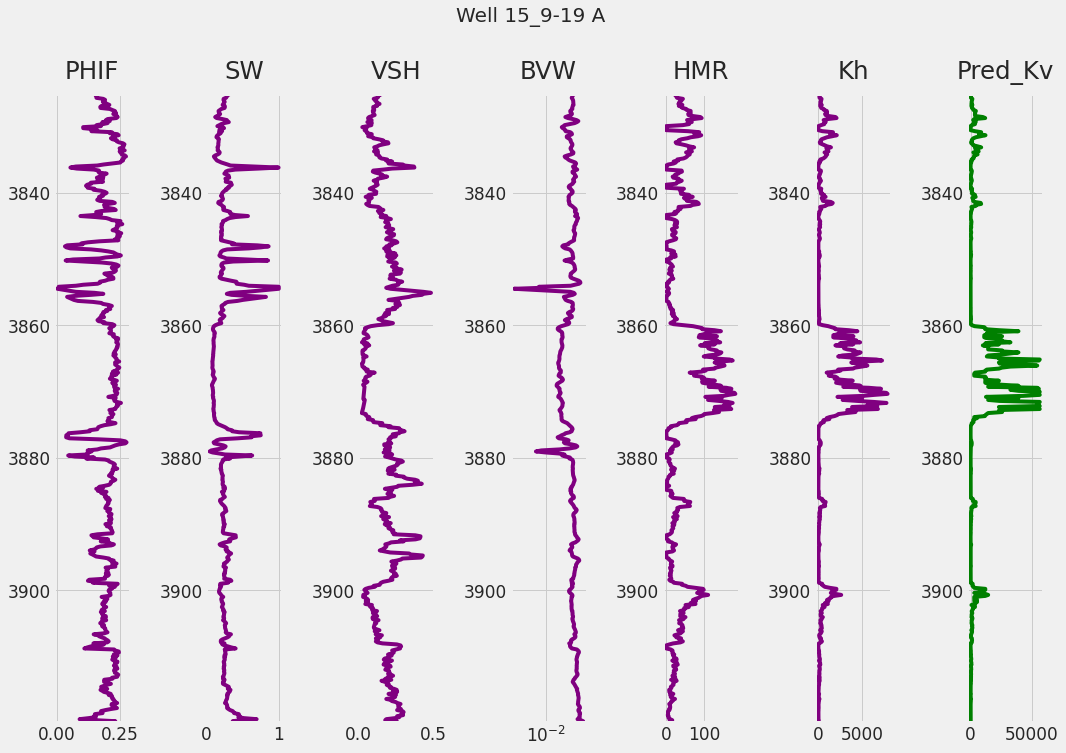

In [324]:
# Display the test data
well = final_pred
# define what logs are we going to us
logs = ['PHIF','SW','VSH','BVW','HMR', 'Kh', 'Kv']

# titles to show
title = ['PHIF','SW','VSH','BVW','HMR', 'Kh', 'Pred_Kv']
# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(15,10))
fig.suptitle('Well 15_9-19 A', size=20, y=1.05)

# looping each log to display in the subplots

colors = ['purple','purple', 'purple', 'purple', 'purple', 'purple', 'green']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_ylim(max(well['DEPTH']), min(well['DEPTH']))
  ax[i].set_title(title[i], pad=15)
  ax[i].grid(True)

#ax[2].set_xlim(0, 200)
plt.tight_layout(1)
plt.show()

In [325]:
well

DEPTH  PHIF   SW  VSH  BVW   HMR     Kh     Kv
1040 3825.09  0.14 0.33 0.16 0.05 19.67  55.93  81.88
1041 3825.24  0.15 0.30 0.14 0.05 23.90  87.22 192.65
1042 3825.39  0.16 0.29 0.13 0.04 27.64 118.74 309.98
1043 3825.54  0.16 0.28 0.13 0.04 27.57 118.14 309.98
1044 3825.70  0.16 0.27 0.12 0.04 29.38 134.62 304.53
...      ...   ...  ...  ...  ...   ...    ...    ...
1658 3919.27  0.12 0.52 0.24 0.06  7.43   6.87  47.33
1659 3919.42  0.09 0.69 0.18 0.06 11.35  11.51  44.44
1660 3919.58  0.15 0.48 0.18 0.07 16.66  42.22 105.80
1661 3919.73  0.23 0.36 0.25 0.08 12.54  36.27  89.45
1662 3919.88  0.13 0.56 0.25 0.07  6.42   5.17   7.31

[619 rows x 8 columns]

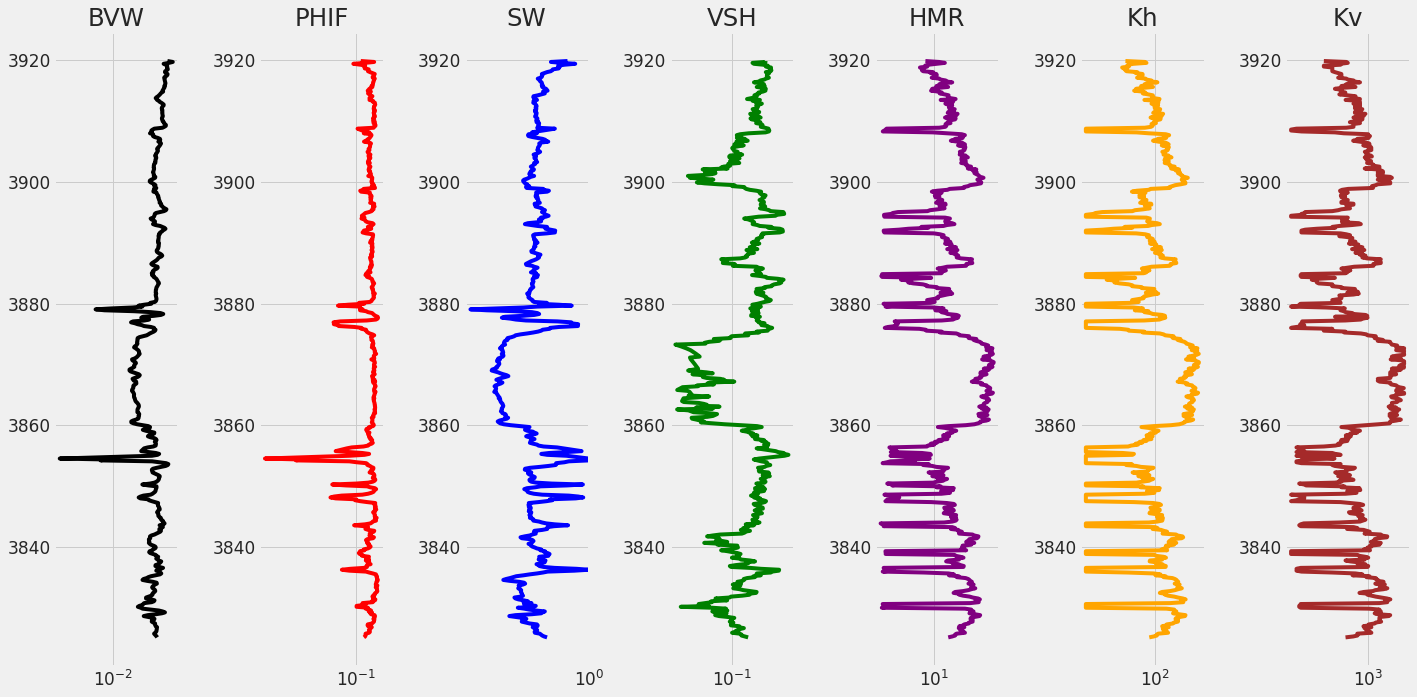

In [326]:
# Display train well data
#well = well_result 

# define what logs are we going to us
logs = ['BVW',	'PHIF',	'SW',	'VSH','HMR',	'Kh',	'Kv']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green', 'purple','orange','brown']

for i in range(len(logs)):
  if i == 4 or 5 or 6:
    
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
   
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 1)
plt.tight_layout(1.1)
plt.show()

In [327]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [328]:
core_data = pd.read_csv("/content/drive/MyDrive/data/15_9-19A-CORE.csv", na_values=' ')
core_data.head()

DEPTH  OrigDepth  CORE_NO  SAMPLE  CKHG  ...  CPORV    So    Sw  CGD  CGDV
0 3838.60    3837.00        1       1 13.80  ...    nan   nan   nan 2.66   nan
1 3838.85    3837.25        1       2   nan  ...    nan   nan   nan 2.67   nan
2 3839.15    3837.55        1       3 25.20  ...    nan   nan   nan 2.69   nan
3 3839.40    3837.80        1       4  1.02  ...    nan   nan   nan 2.70   nan
4 3839.48    3837.88        1       5   nan  ...  18.80 52.90 36.40  nan  2.68

[5 rows x 14 columns]

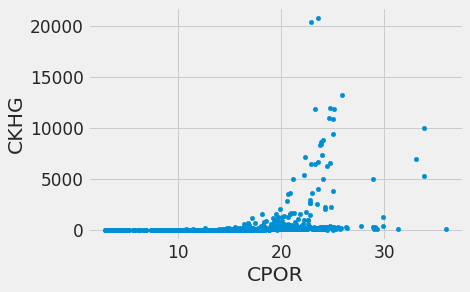

In [329]:
core_data.plot(kind="scatter", x="CPOR", y="CKHG")

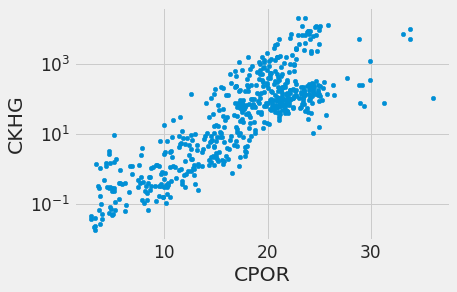

In [330]:
core_data.plot(kind="scatter", x="CPOR", y="CKHG")
plt.yscale('log')
plt.grid(True)

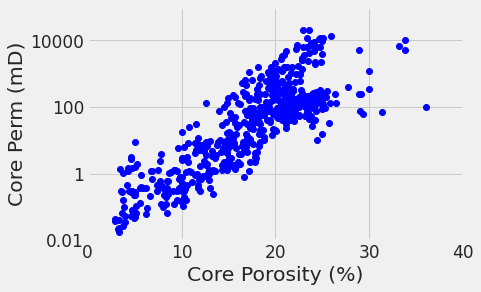

In [331]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 40, 0.01, 100000])
ax.plot(core_data['CPOR'], core_data['CKHG'], 'bo')
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)

In [332]:
##  We can derive a linear regression by using the polyfit function from numpy.
##  As we are working with a semi-log plot, we need to calculate log base 10 of the core permeability.

poro_perm = core_data[['CPOR', 'CKHG']].copy()
poro_perm.dropna(inplace=True)
poro_perm_polyfit = np.polyfit(poro_perm['CPOR'], np.log10(poro_perm['CKHG']), 1)
poro_perm_polyfit

array([ 0.17428705, -1.55607816])

In [333]:
import statsmodels.api as sm

x = core_data['CPOR']
x = sm.add_constant(x)
y = np.log10(core_data['CKHG'])

model = sm.OLS(y, x, missing='drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CKHG   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1340.
Date:                Mon, 19 Jul 2021   Prob (F-statistic):          4.26e-150
Time:                        10:19:50   Log-Likelihood:                -601.06
No. Observations:                 557   AIC:                             1206.
Df Residuals:                     555   BIC:                             1215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5561      0.088    -17.768      0.000      -1.728      -1.384
CPOR           0.1743      0.005     36.602      0.000       0.165       0.184
==============================================================================
Omnibus:                        6.685   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.790
Skew:                           0.254   Prob(JB):                       0.0335
Kurtosis:                       2.816   Cond. No.                         53.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [334]:
results.params

const   -1.56
CPOR     0.17
dtype: float64

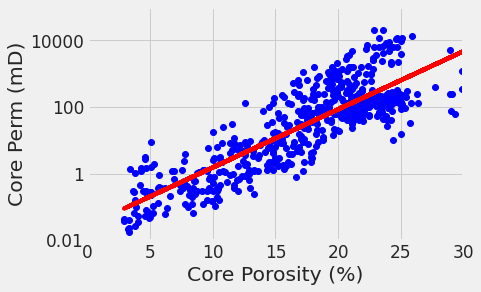

In [335]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 30, 0.01, 100000])
ax.semilogy(core_data['CPOR'], core_data['CKHG'], 'bo')

ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

ax.semilogy(core_data['CPOR'], 10**(results.params[1] * core_data['CPOR'] + results.params[0]), 'r-')


#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)
    
plt.savefig('predicted_poro_perm_xplot.png', dpi=100)


In [336]:
## Equation of porosity and liquid permeability 
print(results.params[0])
print(results.params[1])
final_pred['PERM']= 10**(results.params[1] * (final_pred['PHIF']*100) + results.params[0])

-1.5560781598525875
0.1742870473595356


In [337]:
final_pred


DEPTH  PHIF   SW  VSH  BVW   HMR     Kh     Kv   PERM
1040 3825.09  0.14 0.33 0.16 0.05 19.67  55.93  81.88   9.19
1041 3825.24  0.15 0.30 0.14 0.05 23.90  87.22 192.65  12.72
1042 3825.39  0.16 0.29 0.13 0.04 27.64 118.74 309.98  14.18
1043 3825.54  0.16 0.28 0.13 0.04 27.57 118.14 309.98  14.19
1044 3825.70  0.16 0.27 0.12 0.04 29.38 134.62 304.53  14.50
...      ...   ...  ...  ...  ...   ...    ...    ...    ...
1658 3919.27  0.12 0.52 0.24 0.06  7.43   6.87  47.33   4.10
1659 3919.42  0.09 0.69 0.18 0.06 11.35  11.51  44.44   1.00
1660 3919.58  0.15 0.48 0.18 0.07 16.66  42.22 105.80  12.48
1661 3919.73  0.23 0.36 0.25 0.08 12.54  36.27  89.45 289.25
1662 3919.88  0.13 0.56 0.25 0.07  6.42   5.17   7.31   4.24

[619 rows x 9 columns]

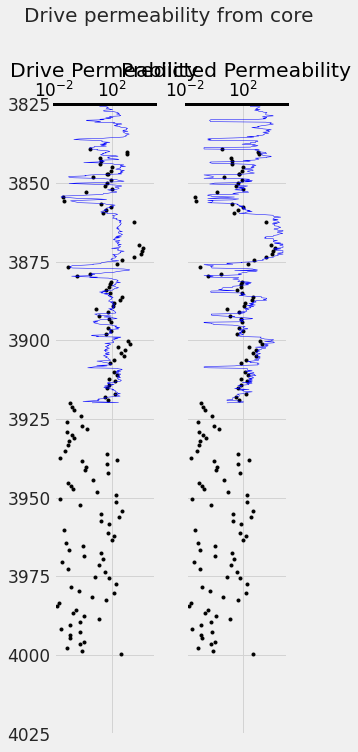

In [338]:
fig, ax = plt.subplots(figsize=(5,10))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

# Porosity track
ax1.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax1.plot(final_pred['PERM'], final_pred['DEPTH'], color ='blue', linewidth=0.5)
ax1.set_xlabel("Drive Permeability")
ax1.set_xlim(0.1,100000)
ax1.xaxis.label.set_color("black")
ax1.tick_params(axis='x', colors="black")
ax1.spines["top"].set_edgecolor("black")
ax1.set_xticks([0.01, 1, 10, 100, 10000])
ax1.semilogx()
# Permeability track
ax2.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax2.plot(final_pred['Kv'], final_pred['DEPTH'], color ='blue', linewidth=0.5)
ax2.set_xlabel("Predicted Permeability")
ax2.set_xlim(0.1, 100000)
ax2.xaxis.label.set_color("black")
ax2.tick_params(axis='x', colors="black")
ax2.spines["top"].set_edgecolor("black")
ax2.set_xticks([0.01, 1, 10, 100, 10000])
ax2.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2]:
    ax.set_ylim(4025, 3825)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
# Removes the y axis labels on the second track
for ax in [ax2]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.suptitle('Drive permeability from core', size=20, y=1.05)
plt.savefig('final_track_plot.png', dpi=100)

# kv vs kh

In [339]:
final_pred.head()

DEPTH  PHIF   SW  VSH  BVW   HMR     Kh     Kv  PERM
1040 3825.09  0.14 0.33 0.16 0.05 19.67  55.93  81.88  9.19
1041 3825.24  0.15 0.30 0.14 0.05 23.90  87.22 192.65 12.72
1042 3825.39  0.16 0.29 0.13 0.04 27.64 118.74 309.98 14.18
1043 3825.54  0.16 0.28 0.13 0.04 27.57 118.14 309.98 14.19
1044 3825.70  0.16 0.27 0.12 0.04 29.38 134.62 304.53 14.50

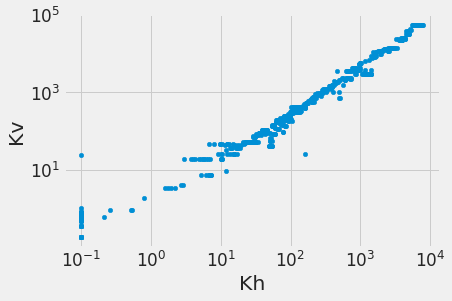

In [340]:
final_pred.plot(kind="scatter", x="Kh", y="Kv")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

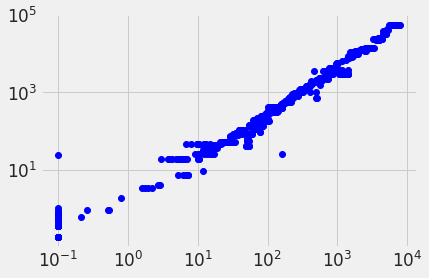

In [341]:
plt.loglog(final_pred['Kh'],final_pred['Kv'], 'bo')
plt.show()

In [342]:
##  We can derive a linear regression by using the polyfit function from numpy.
##  As we are working with a semi-log plot, we need to calculate log base 10 of the core permeability.

poro_perm = final_pred[['Kv','Kh']].copy()
poro_perm.dropna(inplace=True)
poro_perm_polyfit = np.polyfit(np.log10(poro_perm['Kh']), np.log10(poro_perm['Kv']),1)
poro_perm_polyfit

array([1.03378077, 0.45603668])

In [343]:
import statsmodels.api as sm

x = np.log10(final_pred['Kh'])
x = sm.add_constant(x)
y = np.log10(final_pred['Kv'])

model = sm.OLS(y, x, missing='drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Kv   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 2.120e+04
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:19:55   Log-Likelihood:                 38.467
No. Observations:                 619   AIC:                            -72.93
Df Residuals:                     617   BIC:                            -64.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4560      0.016     27.882      0.000       0.424       0.488
Kh             1.0338      0.007    145.615      0.000       1.020       1.048
==============================================================================
Omnibus:                      161.918   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2577.238
Skew:                           0.697   Prob(JB):                         0.00
Kurtosis:                      12.899   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [344]:
results.params

const   0.46
Kh      1.03
dtype: float64

In [345]:
print(results.params[0])
print(results.params[1])

0.45603667920273117
1.0337807657993368


# kv vs phif

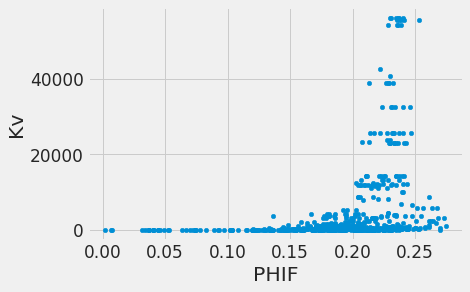

In [346]:
final_pred.plot(kind="scatter", x="PHIF", y="Kv")

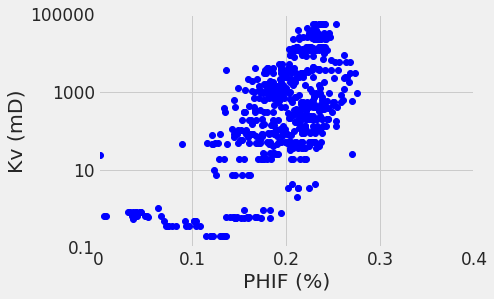

In [347]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 0.40, 0.1, 100000]) ### set x_axis range and y_axis respectively
ax.plot(final_pred['PHIF'], final_pred['Kv'], 'bo')
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Kv (mD)')
ax.set_xlabel('PHIF (%)')

#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)

In [348]:
poro_perm = final_pred[['PHIF', 'Kv']].copy()
poro_perm.dropna(inplace=True)
poro_perm_polyfit = np.polyfit(poro_perm['PHIF'], np.log10(poro_perm['Kv']), 1)
poro_perm_polyfit

array([19.33967971, -1.3385804 ])

In [349]:
import statsmodels.api as sm

x = final_pred['PHIF']
x = sm.add_constant(x)
y = np.log10(final_pred['Kv'])

model = sm.OLS(y, x, missing='drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Kv   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     488.1
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           3.98e-80
Time:                        10:19:56   Log-Likelihood:                -884.76
No. Observations:                 619   AIC:                             1774.
Df Residuals:                     617   BIC:                             1782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3386      0.175     -7.634      0.000      -1.683      -0.994
PHIF          19.3397      0.875     22.092      0.000      17.621      21.059
==============================================================================
Omnibus:                       45.091   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.200
Skew:                          -0.203   Prob(JB):                     6.77e-05
Kurtosis:                       2.238   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [350]:
print(results.params[0])
print(results.params[1])

-1.3385803998499801
19.339679710044624


# comparision




In [351]:
final_pred.head()

DEPTH  PHIF   SW  VSH  BVW   HMR     Kh     Kv  PERM
1040 3825.09  0.14 0.33 0.16 0.05 19.67  55.93  81.88  9.19
1041 3825.24  0.15 0.30 0.14 0.05 23.90  87.22 192.65 12.72
1042 3825.39  0.16 0.29 0.13 0.04 27.64 118.74 309.98 14.18
1043 3825.54  0.16 0.28 0.13 0.04 27.57 118.14 309.98 14.19
1044 3825.70  0.16 0.27 0.12 0.04 29.38 134.62 304.53 14.50

In [352]:
core_data.head()

DEPTH  OrigDepth  CORE_NO  SAMPLE  CKHG  ...  CPORV    So    Sw  CGD  CGDV
0 3838.60    3837.00        1       1 13.80  ...    nan   nan   nan 2.66   nan
1 3838.85    3837.25        1       2   nan  ...    nan   nan   nan 2.67   nan
2 3839.15    3837.55        1       3 25.20  ...    nan   nan   nan 2.69   nan
3 3839.40    3837.80        1       4  1.02  ...    nan   nan   nan 2.70   nan
4 3839.48    3837.88        1       5   nan  ...  18.80 52.90 36.40  nan  2.68

[5 rows x 14 columns]

In [353]:
import math

In [354]:
# correlation formula
df1 = pd.read_excel("/content/sample_data/df1.xlsx")

In [355]:
df1.head()

DEPTH  PHIF   SW  VSH  BVW  ...  KLOGV  kv/kh  PERM  PERMkv  emp_kv
0 3825.09  0.14 0.33 0.16 0.05  ... 130.60   2.34  9.19   26.37  281.65
1 3825.24  0.15 0.30 0.14 0.05  ... 192.26   2.20 12.72   37.39  358.01
2 3825.39  0.16 0.29 0.13 0.04  ... 241.67   2.04 14.18   42.02  428.18
3 3825.54  0.16 0.28 0.13 0.04  ... 241.67   2.05 14.19   42.04  426.84
4 3825.70  0.16 0.27 0.12 0.04  ... 271.93   2.02 14.50   43.02  461.58

[5 rows x 13 columns]

In [356]:
df = core_data.loc[(core_data['DEPTH'] >= 3820) & (core_data['DEPTH'] <= 3920)]

In [357]:
core_data = df

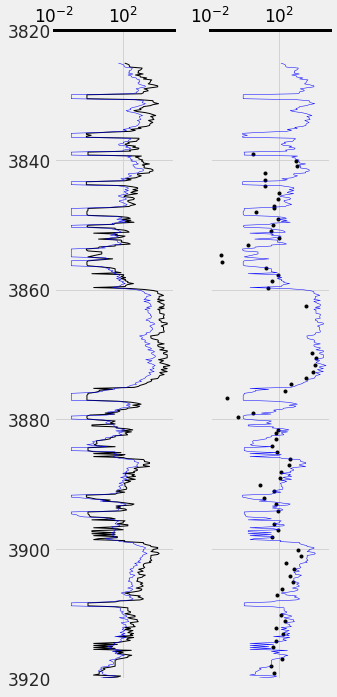

In [358]:
fig, ax = plt.subplots(figsize=(5,10))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

# Porosity track
ax1.plot(df1["KLOGV"], df1['DEPTH'], color = "black", linewidth=1)
ax1.plot(df1['KLOGH'], df1['DEPTH'], color ='blue', linewidth=0.5)
ax1.set_xlabel("")
ax1.set_xlim(0.1,100000)
ax1.xaxis.label.set_color("black")
ax1.tick_params(axis='x', colors="black")
ax1.spines["top"].set_edgecolor("black")
ax1.set_xticks([0.01, 1, 10, 100, 10000])
ax1.semilogx()
# Permeability track
ax2.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax2.plot(df1['KLOGV'], df1['DEPTH'], color ='blue', linewidth=0.5)
ax2.set_xlabel("")
ax2.set_xlim(0.1, 100000)
ax2.xaxis.label.set_color("black")
ax2.tick_params(axis='x', colors="black")
ax2.spines["top"].set_edgecolor("black")
ax2.set_xticks([0.01, 1, 10, 100, 10000])
ax2.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2]:
    ax.set_ylim(3920, 3820)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
# Removes the y axis labels on the second track
for ax in [ax2]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.suptitle('', size=20, y=1.05)
plt.savefig('final_track_2.tiff', dpi=300)

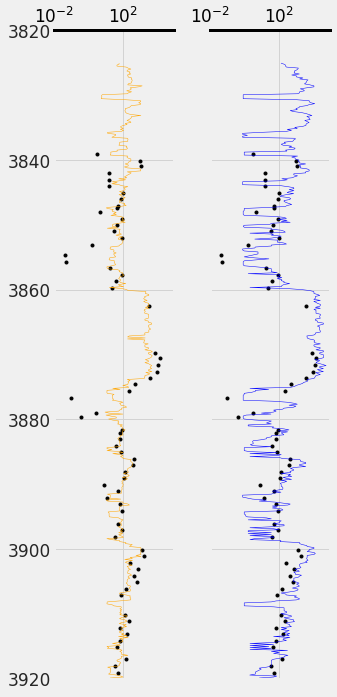

In [374]:
fig, ax = plt.subplots(figsize=(5,10))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

# Porosity track
ax1.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax1.plot(df5['kv_pred'], df1['DEPTH'], color ='orange', linewidth=0.5)
ax1.set_xlabel("")
ax1.set_xlim(0.1,100000)
ax1.xaxis.label.set_color("black")
ax1.tick_params(axis='x', colors="black")
ax1.spines["top"].set_edgecolor("black")
ax1.set_xticks([0.01, 1, 10, 100, 10000])
ax1.semilogx()
# Permeability track
ax2.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax2.plot(df1['KLOGV'], df1['DEPTH'], color ='blue', linewidth=0.5)
ax2.set_xlabel("")
ax2.set_xlim(0.1, 100000)
ax2.xaxis.label.set_color("black")
ax2.tick_params(axis='x', colors="black")
ax2.spines["top"].set_edgecolor("black")
ax2.set_xticks([0.01, 1, 10, 100, 10000])
ax2.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2]:
    ax.set_ylim(3920, 3820)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
# Removes the y axis labels on the second track
for ax in [ax2]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.suptitle('', size=20, y=1.05)
plt.savefig('final_tra.tiff', dpi=300)

In [361]:
df5 = pd.read_csv('/content/sample_data/corewell1.csv')
df5

DEPTH  BVW  PHIF   SW  VSH  KLOGH  kv_pred
0   3825.09 0.05  0.14 0.33 0.16  55.93    60.65
1   3825.24 0.05  0.15 0.30 0.14  87.22    61.38
2   3825.39 0.04  0.16 0.29 0.13 118.74    45.93
3   3825.54 0.04  0.16 0.28 0.13 118.14    45.93
4   3825.70 0.04  0.16 0.27 0.12 134.62   158.92
..      ...  ...   ...  ...  ...    ...      ...
614 3919.27 0.06  0.12 0.52 0.24   6.87    14.84
615 3919.42 0.06  0.09 0.69 0.18  11.51    43.82
616 3919.58 0.07  0.15 0.48 0.18  42.22    77.31
617 3919.73 0.08  0.23 0.36 0.25  36.27   103.29
618 3919.88 0.07  0.13 0.56 0.25   5.17    18.14

[619 rows x 7 columns]

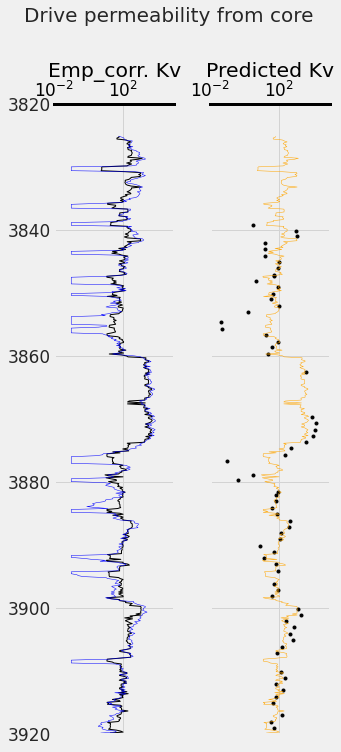

In [365]:
fig, ax = plt.subplots(figsize=(5,10))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

# Porosity track
ax1.plot(df5["kv_pred"], df5['DEPTH'], color = "black", linewidth=1)
ax1.plot(df1['KLOGH'], df1['DEPTH'], color ='blue', linewidth=0.5)
ax1.set_xlabel("Emp_corr. Kv")
ax1.set_xlim(0.1,100000)
ax1.xaxis.label.set_color("black")
ax1.tick_params(axis='x', colors="black")
ax1.spines["top"].set_edgecolor("black")
ax1.set_xticks([0.01, 1, 10, 100, 10000])
ax1.semilogx()
# Permeability track
ax2.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax2.plot(df5['kv_pred'], df5['DEPTH'], color ='orange', linewidth=0.5)
ax2.set_xlabel("Predicted Kv")
ax2.set_xlim(0.1, 100000)
ax2.xaxis.label.set_color("black")
ax2.tick_params(axis='x', colors="black")
ax2.spines["top"].set_edgecolor("black")
ax2.set_xticks([0.01, 1, 10, 100, 10000])
ax2.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2]:
    ax.set_ylim(3920, 3820)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
# Removes the y axis labels on the second track
for ax in [ax2]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.suptitle('Drive permeability from core', size=20, y=1.05)
plt.savefig('final_trak_p.tiff', dpi=300)